In [1]:
import sys
sys.path.append('../Codes/')
sys.path.append('../Codes/Python/')
import numpy as np
import matplotlib.pyplot as plt
from Immuno_models import*
#from Bio import Phylo
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from IPython.display import display, Math
import json

Text_files_path = '../../../../Dropbox/Research/Evolution_Immune_System/Text_files/'

def my_linear_func(x, a, b):
    return a + b*x
def my_quadratic_func(x, a, b, c):
    return np.log(a)+np.log(np.sqrt(-b)) + b*(x-c)**2

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Autosaving every 60 seconds


## Generating Sequences

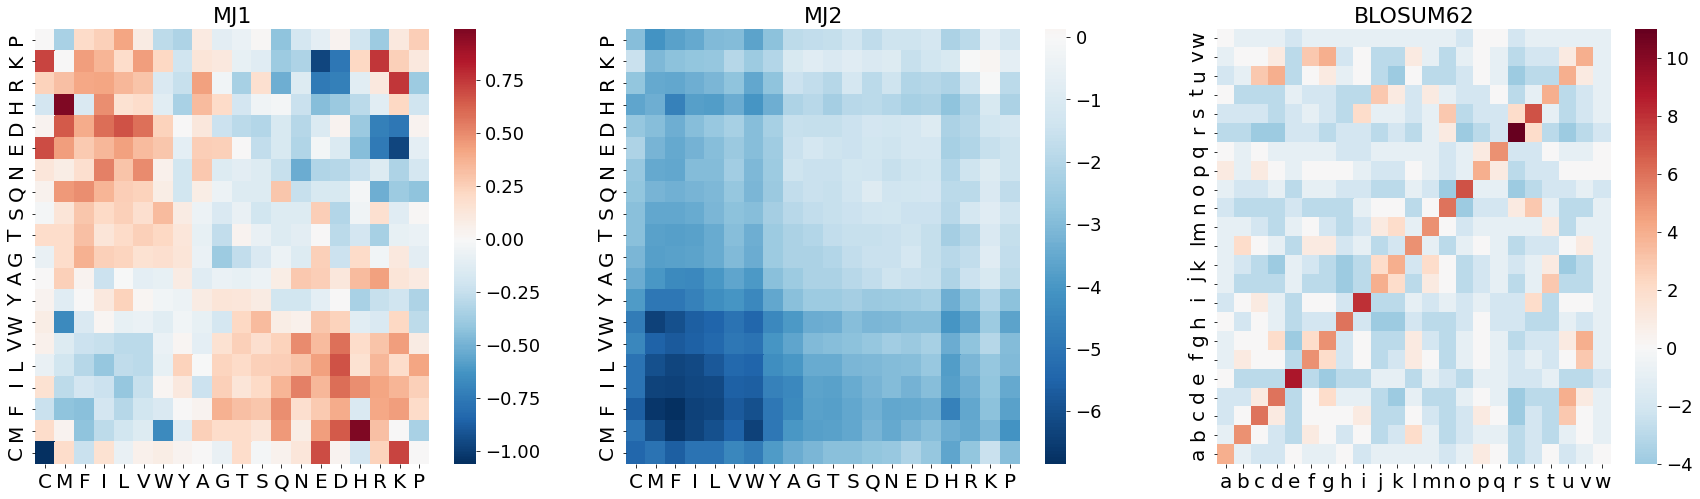

In [2]:
M1 = np.loadtxt(Text_files_path+'MJ.txt', skiprows= 1, usecols=range(1,21)).tolist()
M2 = (np.loadtxt(Text_files_path+'MJ2.txt', skiprows= 1, usecols=range(1,21))).tolist()
M3 = np.loadtxt(Text_files_path+'BLOSUM62.txt', skiprows= 1, max_rows = 23, usecols=range(1,24)).tolist()
Alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
Alphabet2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']
Alphabet = np.loadtxt(Text_files_path + 'Alphabet.txt', dtype=bytes, delimiter='\t').astype(str)
fig, ax = plt.subplots(1,3,figsize=(30,8))

plot_energy_matrix(Energy_Matrix = M1, Alphabet = Alphabet, title = 'MJ1', ax = ax[0])
plot_energy_matrix(Energy_Matrix = M2, Alphabet = Alphabet, title = 'MJ2', ax = ax[1])
plot_energy_matrix(Energy_Matrix = M3, Alphabet = Alphabet2, title = 'BLOSUM62', ax = ax[2])

fig.savefig('../Figures/Energy_matrices.png')

## Single trajectory

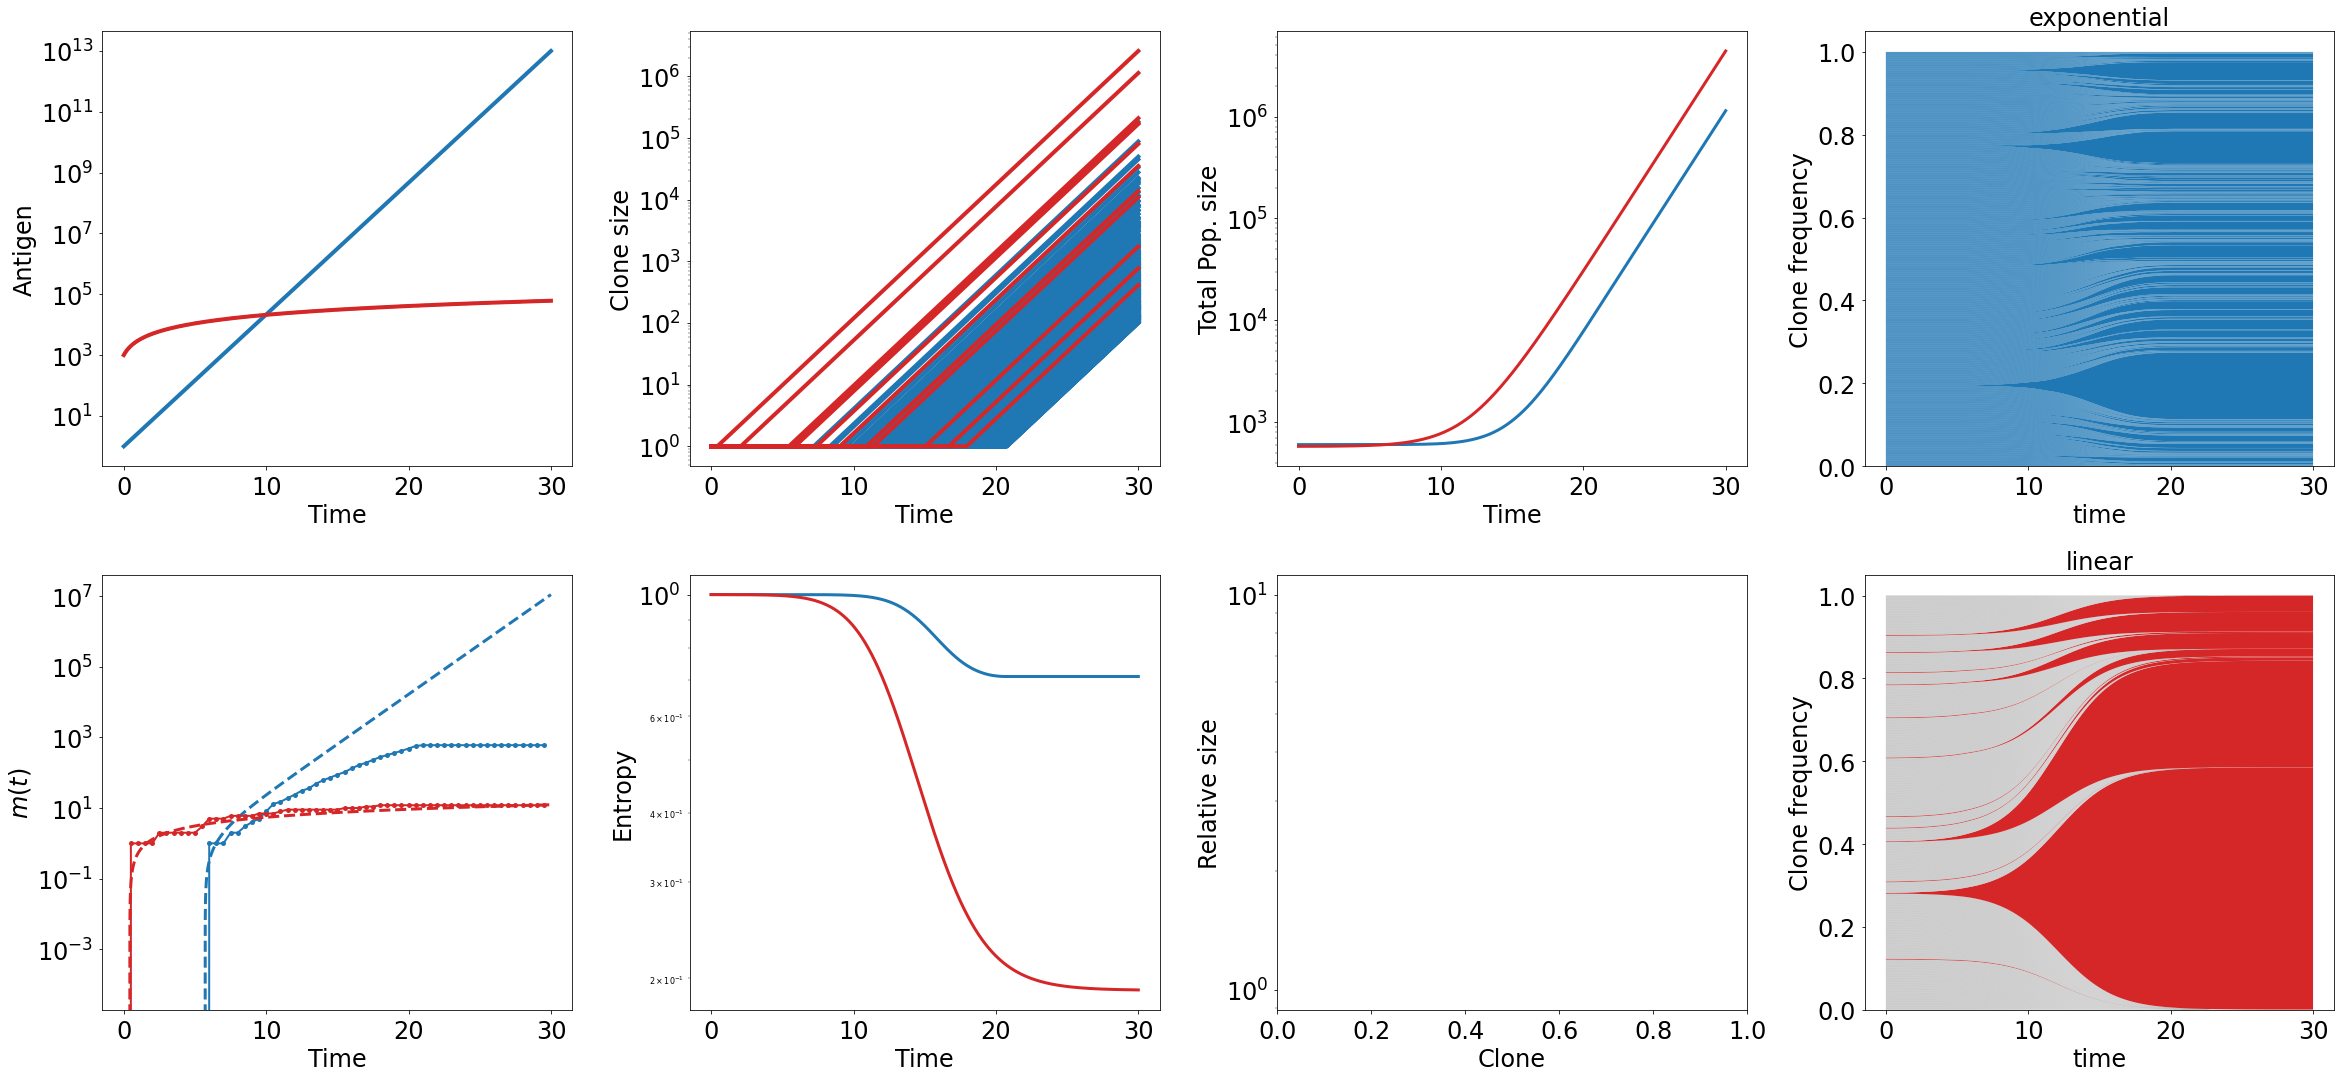

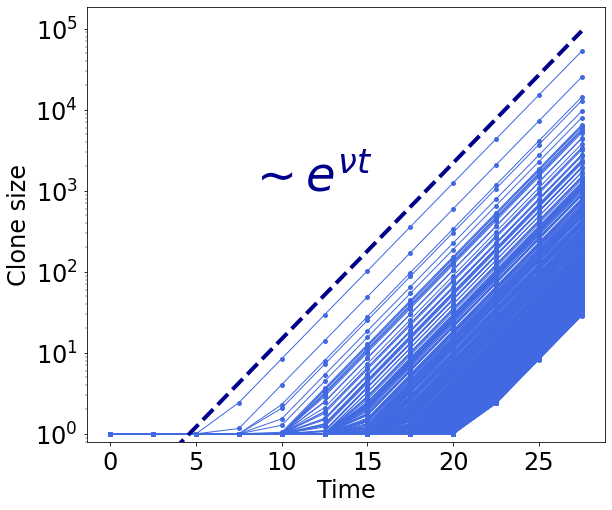

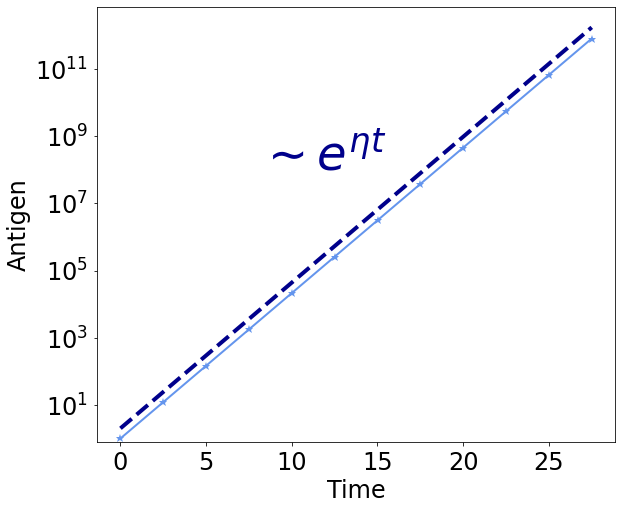

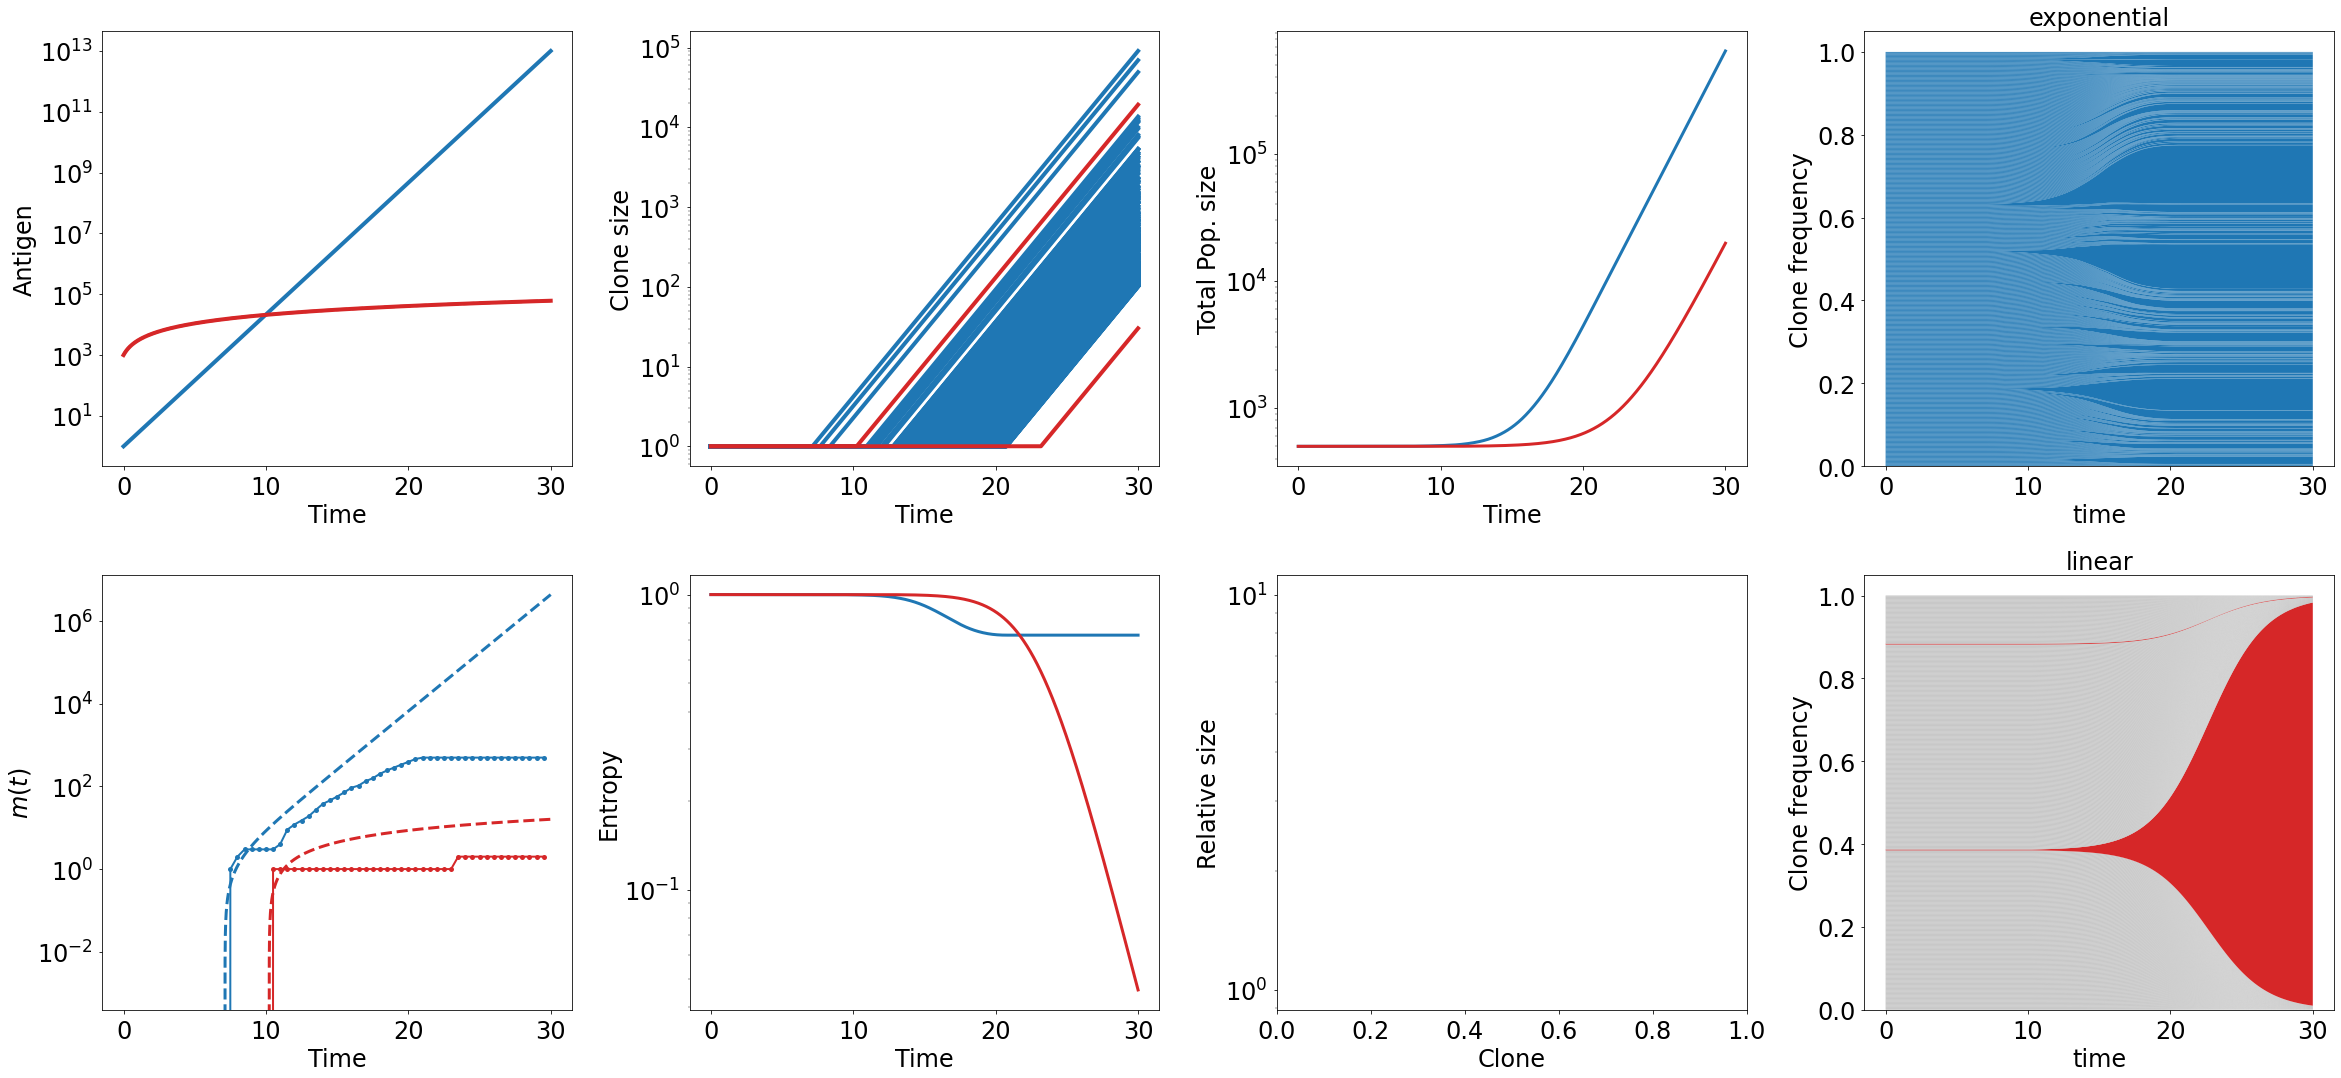

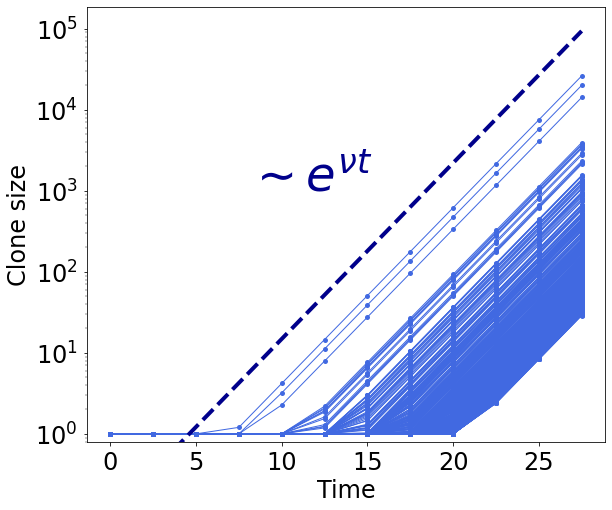

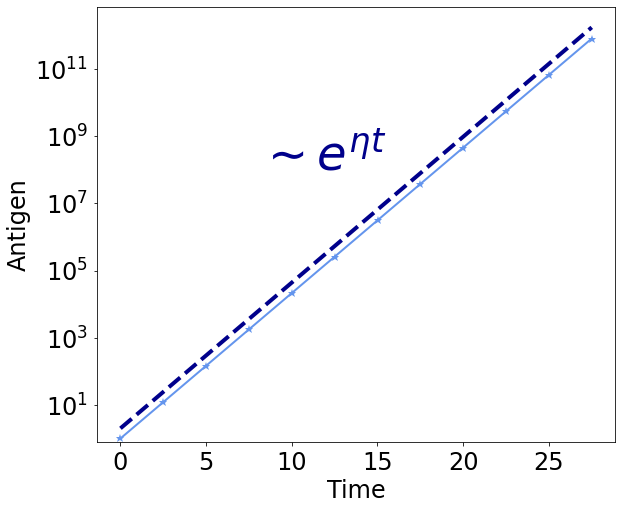

In [20]:
L = 15
NC = 2e3
T0 = 0
Tf = 30
dT = 0.005
eta = 1
gamma = 0.0000
nu = 0.5
linear = 1
antigen = 'TACNSEYPNTTK'
antigen = 'FMLFMAVFVMTSWYC'
time = np.linspace(T0, Tf, int((Tf-T0)/dT))
Types = ['MJ', 'Random']
#Type = 'MJ'
models_name = ['exponential', 'linear', ]
colors = ['tab:blue', 'tab:red']
colors_fit = ['darkblue', 'darkred']
models = [0, 1]
lambd = 0.65

for Type in Types:
    
    fig, ax = plt.subplots(2,4,figsize=(40,18), gridspec_kw={'hspace':0.25, 'wspace':.25})
    fig_b, ax_b = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})
    fig_a, ax_a = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})
    for j, linear in enumerate(models):

        colors_activation = []
        data_antigen = np.loadtxt(Text_files_path + 'Dynamics/Single_trajectory/antigen_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_eta-%.6f_nu-%.6f_gamma-%.6f_linear-%d_'%(eta, nu, gamma, linear)+Type+'.txt')
        data_bcells = np.loadtxt(Text_files_path + 'Dynamics/Single_trajectory/bcells_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_eta-%.6f_nu-%.6f_gamma-%.6f_linear-%d_'%(eta, nu, gamma, linear)+Type+'.txt')
        data_N_active_linages = np.loadtxt(Text_files_path + 'Dynamics/Single_trajectory/N_active_linages_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_eta-%.6f_nu-%.6f_gamma-%.6f_linear-%d_'%(eta, nu, gamma, linear)+Type+'.txt')

        data_bcells_active = np.transpose(data_bcells[:,np.where(data_bcells[-1,:]!=1)[0]])
        final_clone_sizes = data_bcells_active[:, -1]
        final_clone_sizes_sorted = np.flip(np.sort(final_clone_sizes))

        t0 = np.where(data_N_active_linages==0)[0][-1]*dT
        a0 = data_antigen[0]

        for i in data_bcells[-1,:]:
            if(i==1):
                colors_activation.append('silver')
            else:
                colors_activation.append(colors[j])

        #---- Antigen ----
        ax[0,0].plot(time, data_antigen, color = colors[j], label = models_name[j] + ' growth', linewidth = 4, linestyle  = '-', marker = '', ms = 10)
        if(linear == 0):
            expfit = 2*np.exp(eta*time)
            ax_a.plot(time[::500], data_antigen[::500], color = 'cornflowerblue', linewidth = 2, linestyle  = '-', marker = '*', ms = 9);
            ax_a.plot(time[::500], expfit[::500], color = colors_fit[j], linestyle = '--', linewidth = 4)
            ax_a.text(x=8, y=1e8, s = r'$\sim e^{\eta t}$', fontsize=48, color = colors_fit[j])
            my_plot_layout(ax = ax_a, yscale = 'log', xlabel = 'Time', ylabel = 'Antigen')
            ax_a.set_ylim(bottom = .8)
            fig_a.savefig('../Figures/1_Dynamics/Antigen_expansion_'+Type+'.pdf')
        if(linear == 1):
            ax[0,0].plot(time, 1e3 + time*2000, color = colors[j], label = models_name[j] + ' growth', linestyle = '--', linewidth = 3)
        my_plot_layout(ax = ax[0,0], yscale = 'log', xlabel = 'Time', ylabel = 'Antigen')
        #ax[0,0].set_ylim(bottom = 1)

        #---- B cell linages ----
        for i in range(int(data_N_active_linages[-1])):
            ax[0,1].plot(time, data_bcells_active[i,:], color = colors[j], linewidth = 4, linestyle  = '-', marker = '', ms = 12);
        my_plot_layout(ax = ax[0,1], yscale = 'log', xlabel = 'Time', ylabel = 'Clone size')
        if(linear == 0):
            expfit = 1e-1*np.exp(nu*time)
            for i in range(int(data_N_active_linages[-1])):
                ax_b.plot(time[::500], data_bcells_active[i,:][::500], color = 'royalblue', linewidth = 1, linestyle  = '-', marker = 'o', ms = 5);
            ax_b.plot(time[::500], expfit[::500], color = colors_fit[j], linestyle = '--', linewidth = 4)
            ax_b.text(x=8, y=1e3, s = r'$\sim e^{\nu t}$', fontsize=48, color = colors_fit[j])
            my_plot_layout(ax = ax_b, yscale = 'log', xlabel = 'Time', ylabel = 'Clone size')
            ax_b.set_ylim(bottom = .8)
            fig_b.savefig('../Figures/1_Dynamics/B_cells_expansion_'+Type+'.pdf')
        #---- Activation rate ----
        ax[1,0].plot(time[::100], data_N_active_linages[::100], linestyle = '-', marker = 'o', ms = 5, linewidth = 2, label = 'simulation', color = colors[j])
        if(linear == 0):
            theory = (1/(eta*lambd))*(np.exp(eta*lambd*(time-t0))-1)
            ax[1,0].plot(time, theory, color = colors[j], label = models_name[j] + ' growth', linestyle = '--', linewidth = 3)
        if(linear == 1):
            theory = ((1/(eta*2000*(lambd)*(eta*2000*t0+a0)**(lambd-1)))*((eta*2000*time+a0)**(lambd)-(eta*2000*t0+a0)**(lambd)))
            #theory = time**(lambd)
            ax[1,0].plot(time, theory, color = colors[j], label = models_name[j] + ' growth', linestyle = '--', linewidth = 3)
        my_plot_layout(ax = ax[1,0], xscale = 'linear', yscale = 'log', xlabel = 'Time', ylabel = r'$m(t)$')

        #---- Entropy ----
        total_pop = np.sum(np.transpose(data_bcells), axis = 0)
        bcell_freqs = np.transpose(data_bcells)/total_pop
        entropy = -np.sum(bcell_freqs*np.log(bcell_freqs), axis = 0)
        ax[1,1].plot(time, entropy/entropy[0], color = colors[j], linewidth = 3)
        my_plot_layout(ax = ax[1,1], yscale = 'log', xlabel = 'Time', ylabel = 'Entropy')

        #---- Total Pop size ----
        ax[0,2].plot(time, total_pop, color = colors[j], linewidth = 3)
        my_plot_layout(ax = ax[0,2], xlabel = 'Time', ylabel = 'Total Pop. size', yscale = 'log')

        #---- Relative clone sizes ----
        #ax[1,2].plot(range(1,int(8+1)), final_clone_sizes_sorted[:8]/final_clone_sizes_sorted[0], color = colors[j], linewidth = .5, linestyle = '--', marker = '^', ms = 15)
        my_plot_layout(ax = ax[1,2], xlabel = 'Clone', ylabel = 'Relative size', yscale = 'log')
        #ax[1,2].set_xlim(right = 8)

        #---- Stackplots ----
        ax[j, 3].stackplot(time, bcell_freqs, colors = colors_activation);
        my_plot_layout(ax = ax[j, 3], ticks_labelsize=24, title=models_name[j], xlabel = 'time', ylabel = 'Clone frequency')

    fig.savefig('../Figures/1_Dynamics/summary_1_single_trajectory_'+Type+'.pdf')
    


-76 -58


/Users/robertomorantovar/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/robertomorantovar/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-76 -58


/Users/robertomorantovar/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/robertomorantovar/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-76 -58


/Users/robertomorantovar/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/robertomorantovar/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-76 -58


/Users/robertomorantovar/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/robertomorantovar/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


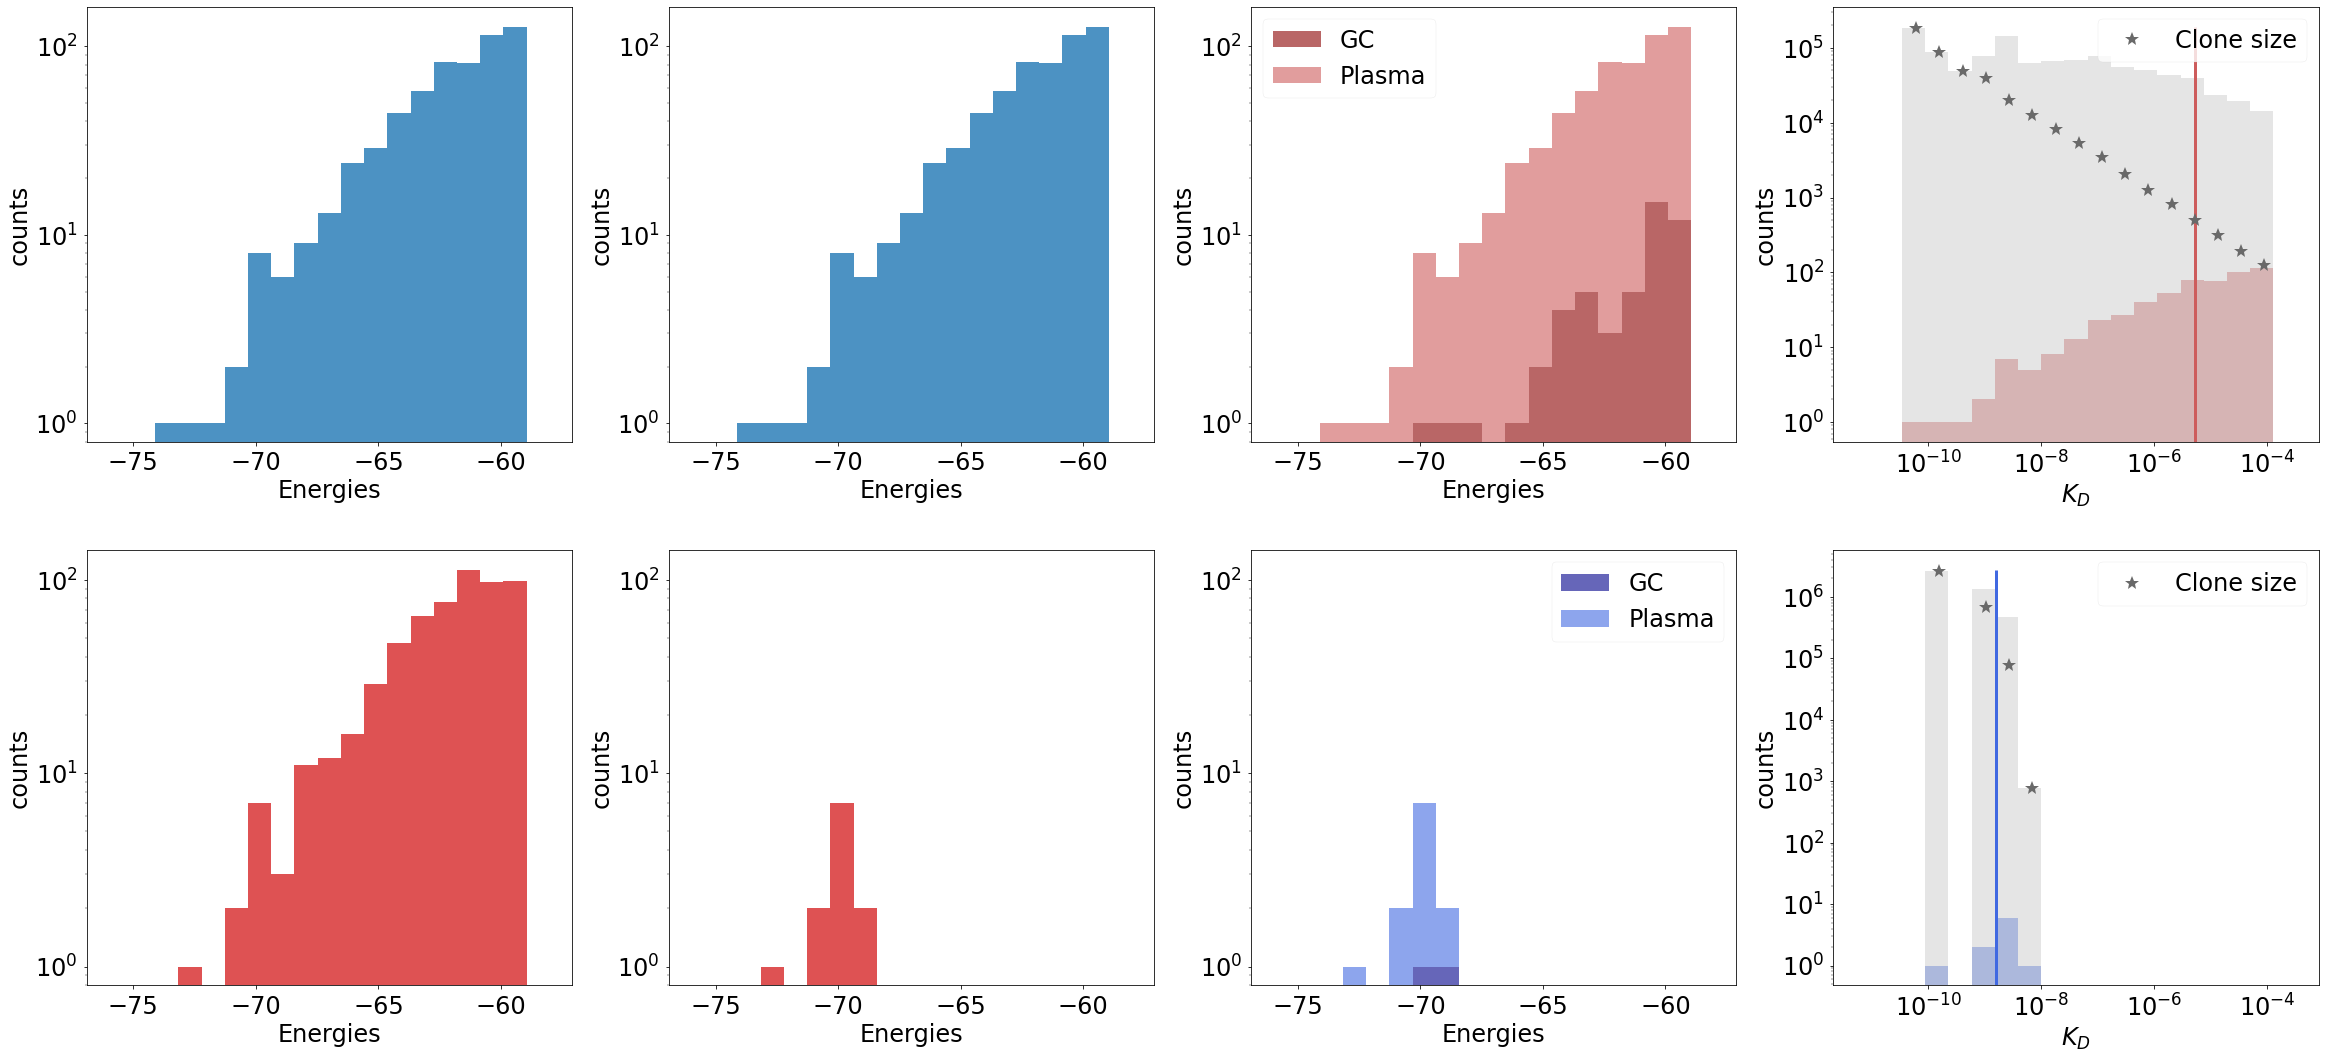

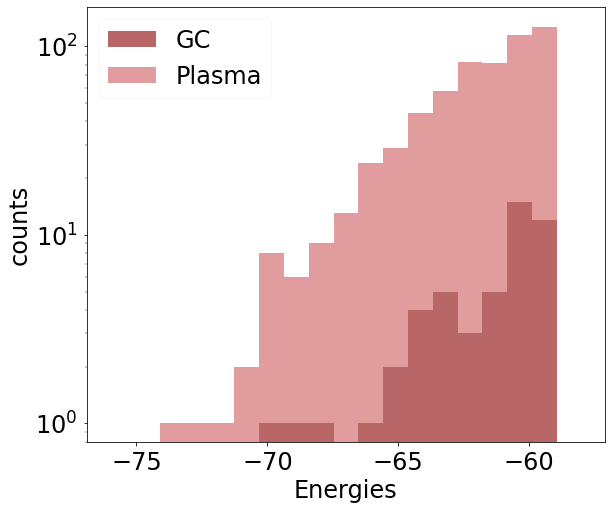

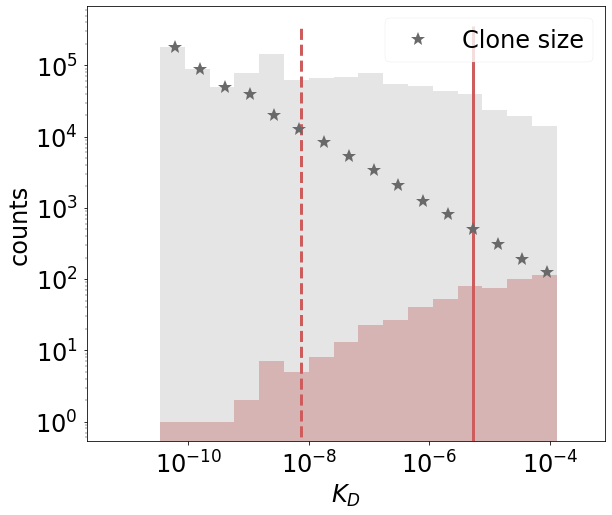

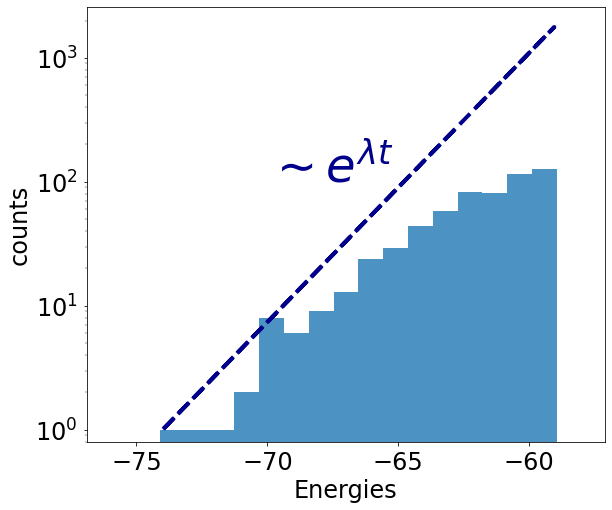

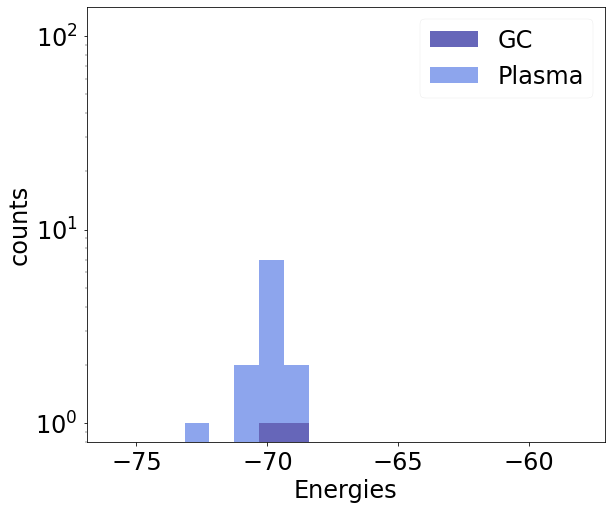

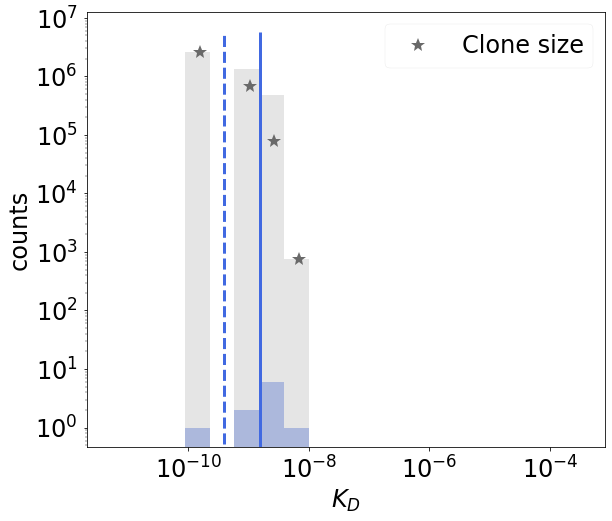

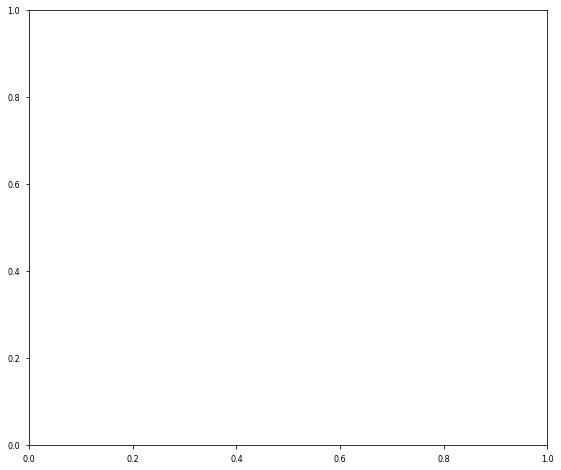

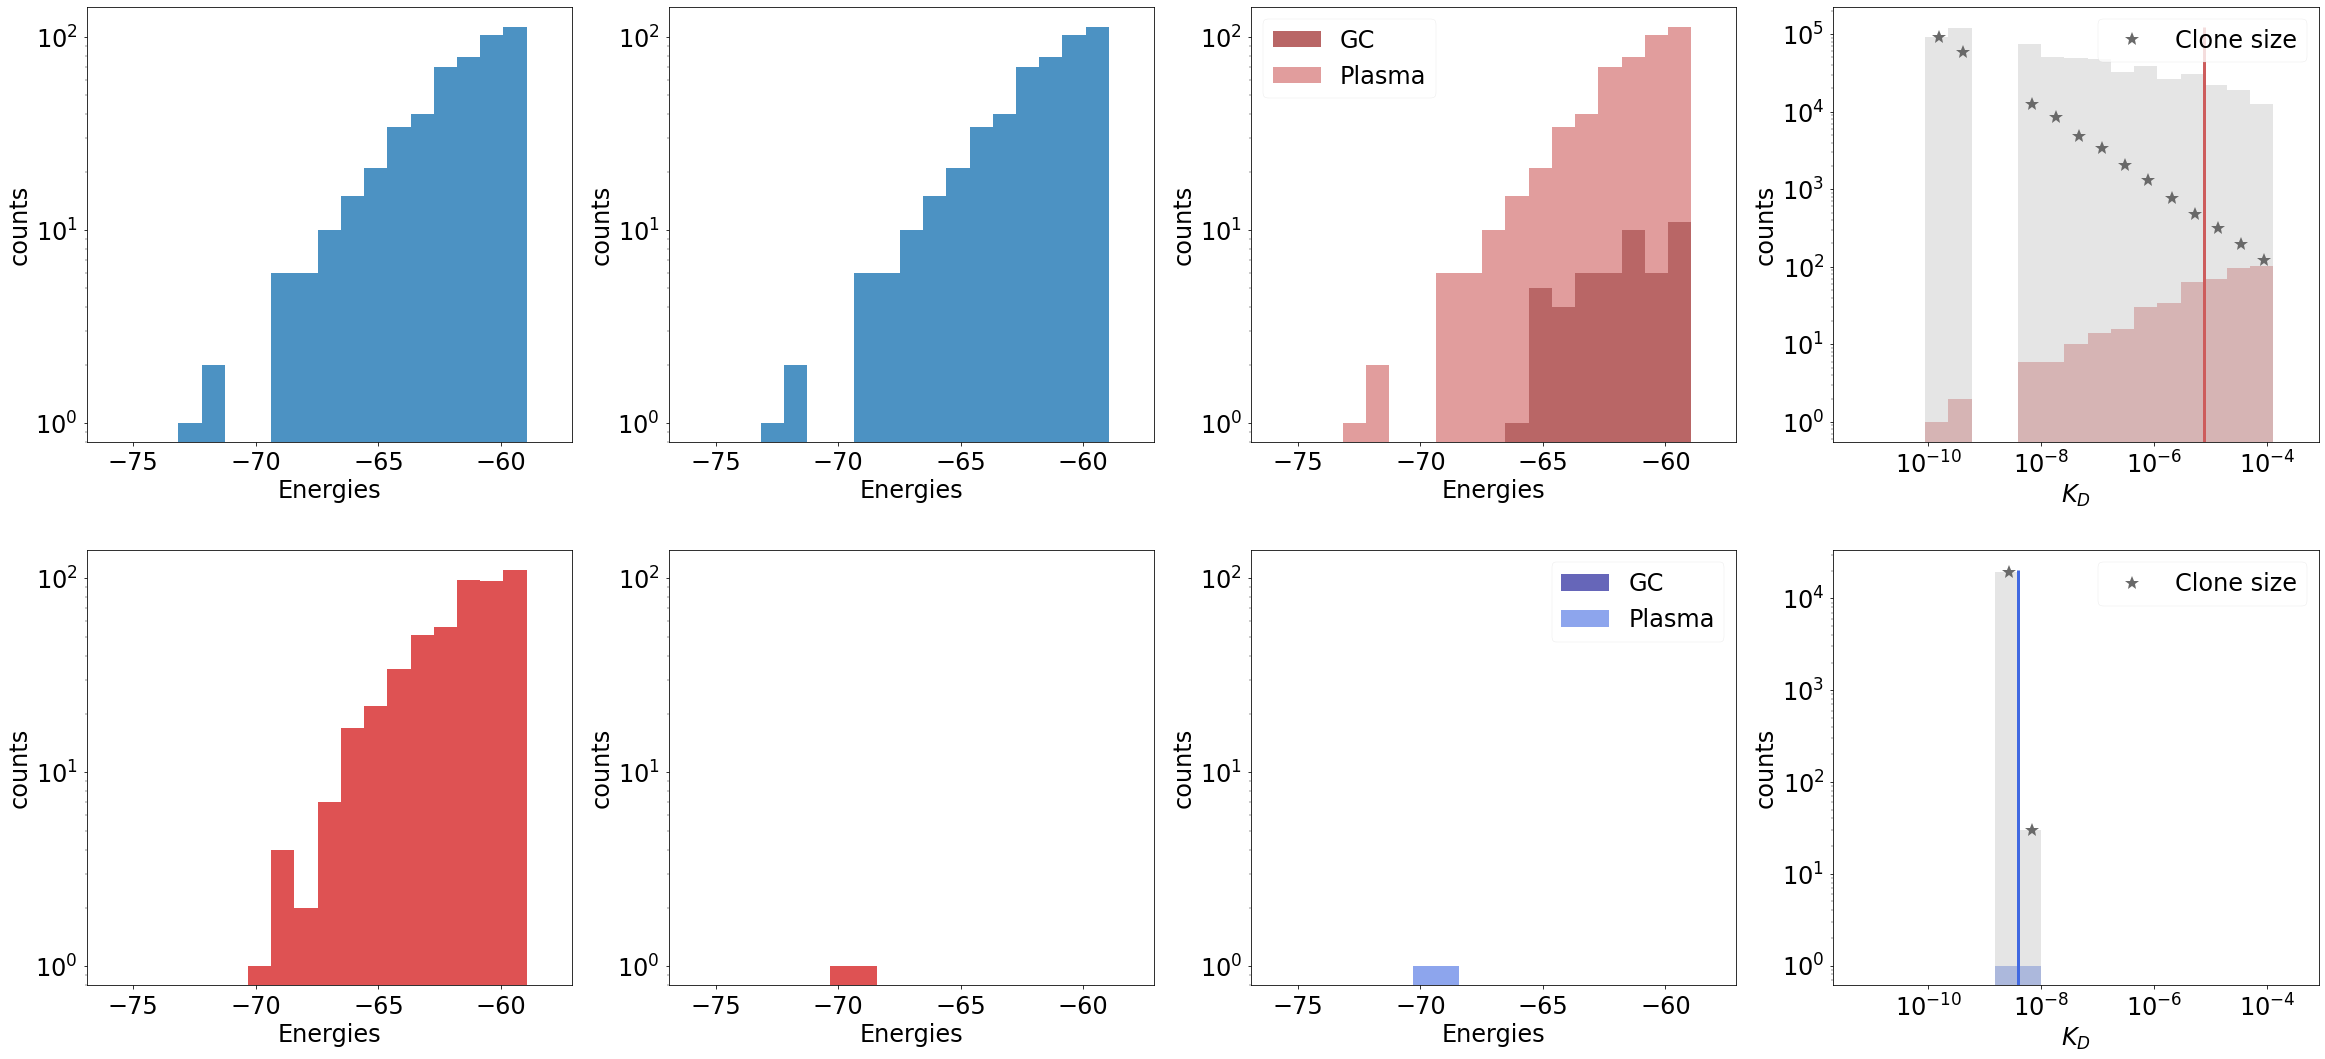

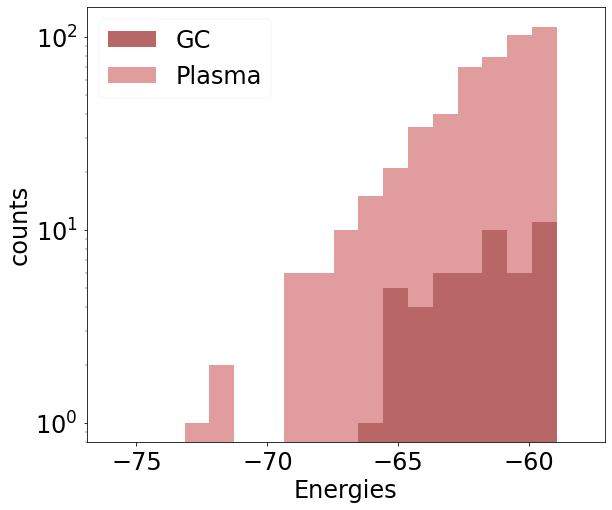

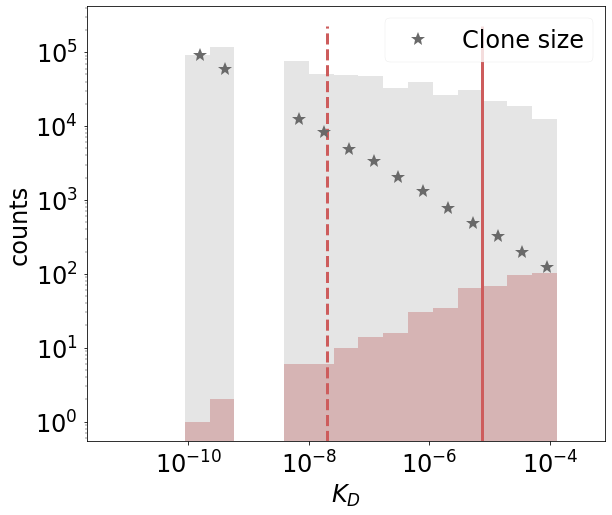

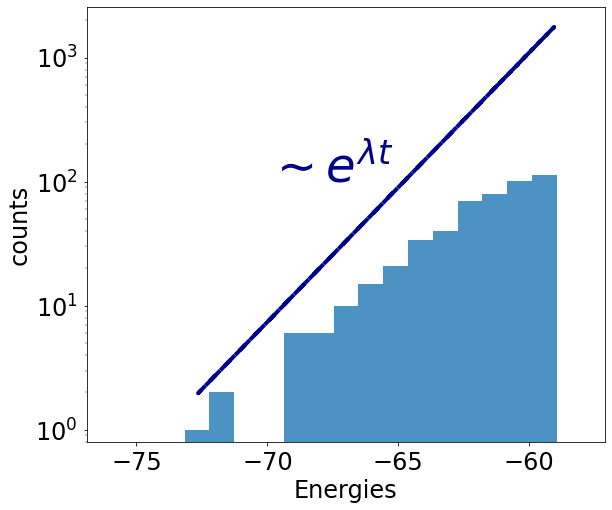

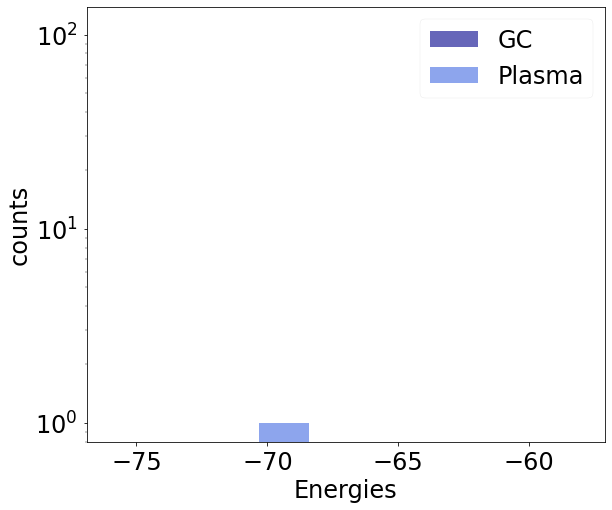

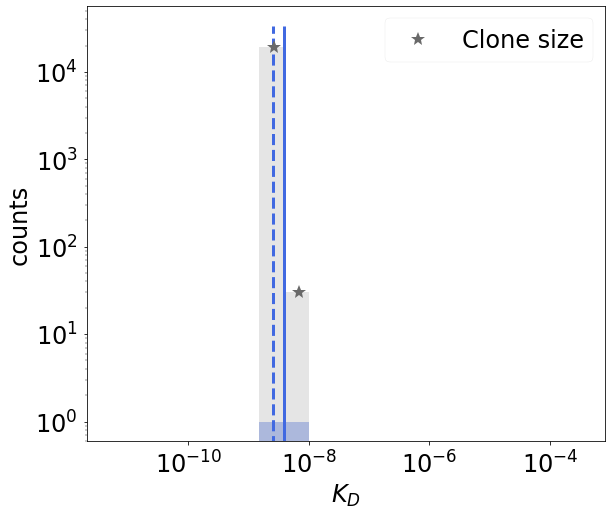

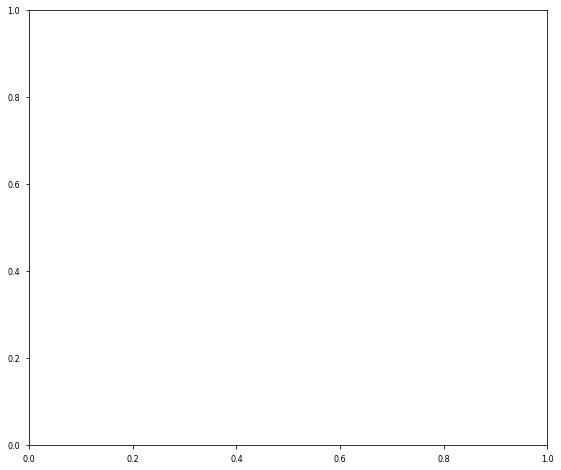

In [17]:

#fig2, ax2 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})
#fig3, ax3 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})

colors_fate = [['darkred', 'indianred'], ['darkblue', 'royalblue']]

min_e = -76
max_e = -58
gauge_e = 50

lambd = 0.50

for Type in Types:
    
    fig, ax = plt.subplots(2,4,figsize=(40,18), gridspec_kw={'hspace':0.25})

    for j, linear in enumerate(models):

        fig2, ax2 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})
        fig3, ax3 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})
        fig_seq, ax_seq = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})


        colors_activation = []
        data_bcells = np.loadtxt(Text_files_path + 'Dynamics/Single_trajectory/bcells_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_eta-%.6f_nu-%.6f_gamma-%.6f_linear-%d_'%(eta, nu, gamma, linear)+Type+'.txt')
        data_energies = np.loadtxt(Text_files_path + 'Dynamics/Single_trajectory/energies_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_linear-%d_'%(linear)+Type+'.txt')

        #min_e = np.min(data_energies[:,0])
        #max_e = np.max(data_energies[:,0])
        print(min_e, max_e)

        data_bcells_active = np.transpose(data_bcells[:,np.where(data_energies[:,1]==1)[0]])

        energies_active = data_energies[np.where(data_energies[:,1]==1)[0],:]

        #print(np.min(data_energies))
        #---- distribution energies ----
        ax[j,0].hist(data_energies[:,0], bins = np.linspace(min_e, max_e, 20), color = colors[j], alpha = .8, histtype = 'bar')
        my_plot_layout(ax = ax[j,0], yscale = 'log', xlabel = 'Energies', ylabel = 'counts')
        ax[j,0].set_ylim(bottom = .8)
        if(linear == 0):
            expfit = np.exp(lambd*(data_energies[:,0]+74))
            ax_seq.hist(data_energies[:,0], bins = np.linspace(min_e, max_e, 20), color = colors[j], alpha = .8, histtype = 'bar')
            ax_seq.plot(data_energies[:,0], expfit, color = colors_fit[j], linestyle = '--', linewidth = 4)
            ax_seq.text(x=-70, y=1e2, s = r'$\sim e^{\lambda t}$', fontsize=48, color = colors_fit[j])
            my_plot_layout(ax = ax_seq, yscale = 'log', xlabel = 'Energies', ylabel = 'counts')
            ax_seq.set_ylim(bottom = .8)
            fig_seq.savefig('../Figures/1_Dynamics/Sequences_expansion_'+Type+'.pdf')

        #---- distribution activated energies ----
        ax[j,1].hist(energies_active[:,0], bins = np.linspace(min_e, max_e, 20), color = colors[j], alpha = .8, histtype = 'bar')
        my_plot_layout(ax = ax[j,1], yscale = 'log', xlabel = 'Energies', ylabel = 'counts')
        ax[j,1].set_ylim(bottom = ax[j,0].get_ylim()[0], top=ax[j,0].get_ylim()[1])

        #---- distribution Gc vs Plasma ----
        ax[j,2].hist([energies_active[np.where(energies_active[:,2]==1)[0],0], energies_active[np.where(energies_active[:,2]==0)[0],0]], bins = np.linspace(min_e, max_e, 20), color = colors_fate[j], alpha = .6, histtype = 'barstacked', label = ['GC', 'Plasma'])
        my_plot_layout(ax = ax[j,2], yscale = 'log', xlabel = 'Energies', ylabel = 'counts')
        ax[j,2].set_ylim(bottom = ax[j,0].get_ylim()[0], top=ax[j,0].get_ylim()[1])
        ax[j,2].legend(fontsize = 24)

        ax2.hist([energies_active[np.where(energies_active[:,2]==1)[0],0], energies_active[np.where(energies_active[:,2]==0)[0],0]], bins = np.linspace(min_e, max_e, 20), color = colors_fate[j], alpha = .6, histtype = 'barstacked', label = ['GC', 'Plasma'])
        my_plot_layout(ax = ax2, yscale = 'log', xlabel = 'Energies', ylabel = 'counts')
        ax2.set_ylim(bottom = ax[j,0].get_ylim()[0], top=ax[j,0].get_ylim()[1])
        ax2.legend(fontsize = 24)

        #---- Sera ----
        clone_sizes = data_bcells_active[np.where(energies_active[:,2]==0)[0],-1]
        Kds = np.exp(energies_active[np.where(energies_active[:,2]==0)[0],0]+gauge_e)
        data_Kds = ax[j,3].hist(Kds, bins = np.logspace(np.log10(np.exp(min_e+gauge_e)), np.log10(np.exp(max_e+gauge_e)), 20), density = False, color = colors_fate[j][1], alpha = .5, histtype = 'bar')
        ax[j,3].hist(Kds, bins = np.logspace(np.log10(np.exp(min_e+gauge_e)), np.log10(np.exp(max_e+gauge_e)), 20), density = False, color = 'silver', alpha = .4, histtype = 'bar', weights = data_bcells_active[np.where(energies_active[:,2]==0)[0],-1])
        clone_sizes_binned = np.array([])
        for i in range(int(len(data_Kds[0]))):
            clone_sizes_binned = np.append(clone_sizes_binned, np.mean(clone_sizes[(Kds<data_Kds[1][i+1]) & (Kds>data_Kds[1][i])]))
        ax[j,3].plot((data_Kds[1][:-1]+data_Kds[1][1:])/2, clone_sizes_binned, color = 'dimgray', linewidth =3, linestyle = '', marker = '*', ms = 15, label = 'Clone size')
        ax[j,3].vlines(np.exp(np.average(np.log(Kds))), 0, ax[j,3].get_ylim()[1], color = colors_fate[j][1], linewidth = 3, linestyle = '-')
        #ax[j,3].vlines(np.exp(np.average(np.log(Kds), weights = data_bcells_active[np.where(energies_active[:,2]==0)[0],-1])), 0, ax[j,3].get_ylim()[1], color = colors_fate[j][1], linewidth = 3, linestyle = '--')
        my_plot_layout(ax = ax[j,3], yscale = 'log', xscale = 'log', xlabel = r'$K_D$', ylabel = 'counts')
        ax[j,3].legend(fontsize = 24)

        ax3.hist(Kds, bins = np.logspace(np.log10(np.exp(min_e+gauge_e)), np.log10(np.exp(max_e+gauge_e)), 20), density = False, color = colors_fate[j][1], alpha = .5, histtype = 'bar')
        ax3.hist(Kds, bins = np.logspace(np.log10(np.exp(min_e+gauge_e)), np.log10(np.exp(max_e+gauge_e)), 20), density = False, color = 'silver', alpha = .4, histtype = 'bar', weights = data_bcells_active[np.where(energies_active[:,2]==0)[0],-1])
        ax3.plot((data_Kds[1][:-1]+data_Kds[1][1:])/2, clone_sizes_binned, color = 'dimgray', linewidth =3, linestyle = '', marker = '*', ms = 15, label = 'Clone size')
        ax3.vlines(np.exp(np.average(np.log(Kds))), 0, ax[j,3].get_ylim()[1], color = colors_fate[j][1], linewidth = 3, linestyle = '-')
        ax3.vlines(np.exp(np.average(np.log(Kds), weights = data_bcells_active[np.where(energies_active[:,2]==0)[0],-1])), 0, ax[j,3].get_ylim()[1], color = colors_fate[j][1], linewidth = 3, linestyle = '--')
        my_plot_layout(ax = ax3, yscale = 'log', xscale = 'log', xlabel = r'$K_D$', ylabel = 'counts')
        ax3.legend(fontsize = 24)

        #fig2.savefig("../Figures/1_Dynamics/Plasma_vs_GC_linear-%d.pdf"%(linear))
        #fig3.savefig("../Figures/1_Dynamics/Sera_linear-%d.pdf"%(linear))


    fig.savefig('../Figures/1_Dynamics/summary_2_single_trajectory_'+Type+'.pdf')
    fig2.savefig("../Figures/1_Dynamics/Plasma_vs_GC_"+Type+".pdf")
    fig3.savefig("../Figures/1_Dynamics/Sera_"+Type+".pdf")
             

In [612]:
np.sqrt(20.620002/15)

1.1724618543901546

## Ensemble of trajectories

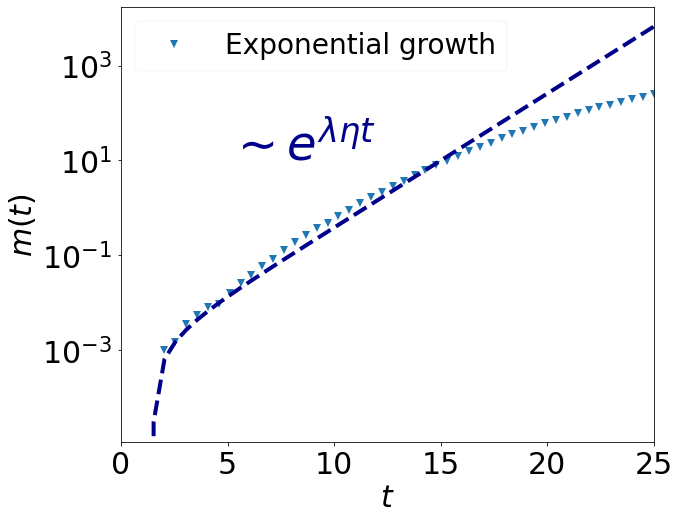

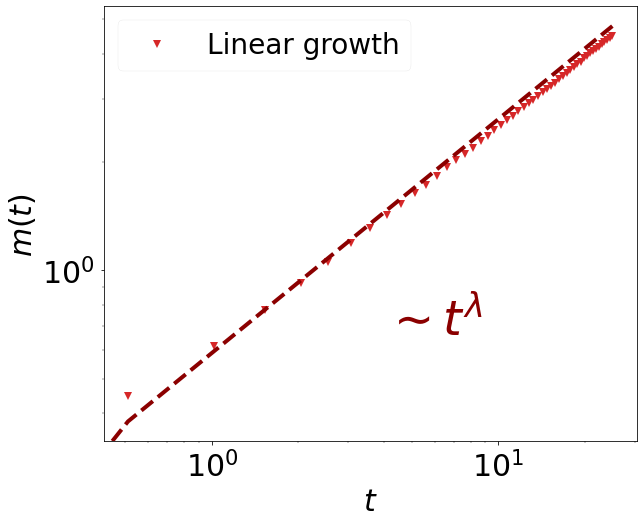

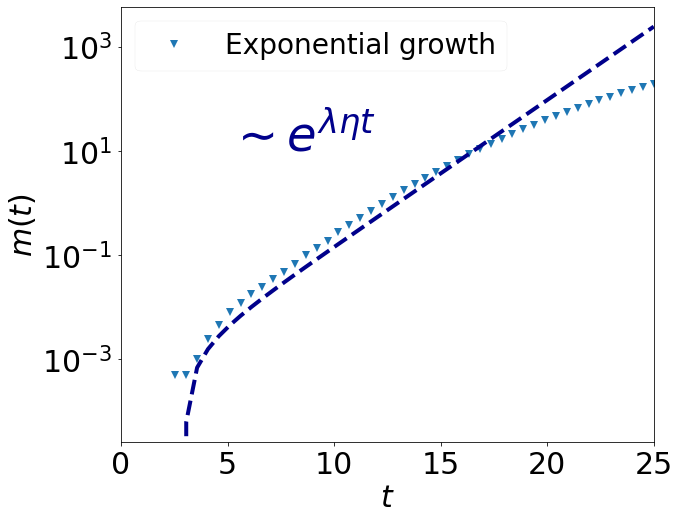

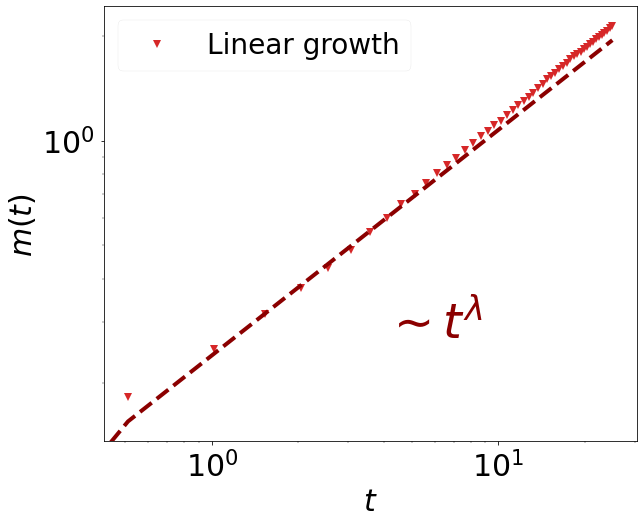

In [18]:
L = 15
NC = 2e3
T0 = 0
Tf = 25
dT = 0.5
eta = 1
gamma = .0000
nu = 0.5

lambd = 0.62

Types = ['MJ','Random']

#b = 1.62
#b = 1.97
#b = 2.08
#-------------------------
models = [0, 1]
models_name = ['Exponential', 'Linear']
colors = ['tab:blue','tab:red']
colors_fit = ['darkblue', 'darkred']
exponents = [-1, (-((eta*lambd)/nu)-1)]

for Type in Types:

    fig2, ax2 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.16})
    fig3, ax3 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.16})

    for i, linear in enumerate(models):

        time = np.linspace(T0, Tf, int((Tf-T0)/dT))
        #data_energies_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/energies_tail_ensemble_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_linear-%d.txt'%(linear))
        data_N_active_linages_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/N_active_linages_ensemble_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_eta-%.6f_nu-%.6f_gamma-%.6f_linear-%d_'%(eta, nu, gamma, linear)+Type+'.txt')

        #-------------------------

        t0 = np.where(data_N_active_linages_ensemble==0)[0][-1]*dT

        if(models[i]==0): #Exponential
            lambd = 0.65
            #-------------------------------------------
            plaw_fit = ((1e-3))*(1/(eta*lambd))*(np.exp(eta*lambd*(time[::]-t0))-1)
            #plaw_fit = 1e-3*(np.exp(eta*lambd*(time[::]-t0)))
            ax2.plot(time[::], np.cumsum(data_N_active_linages_ensemble[::]*dT), colors[i], linestyle = '', marker = 'v', ms = 8, linewidth = 4, label = models_name[i]+" growth")
            #ax2.plot(time[::], data_N_active_linages_ensemble[::], colors[i], linestyle = '-', marker = '', ms = 8, linewidth = 4, label = models_name[i]+" growth")
            ax2.plot(time[::], plaw_fit, color = colors_fit[i], linestyle = '--', linewidth = 4)
            ax2.text(x=5e0, y=1e1, s = r'$\sim e^{\lambda \eta t}$', fontsize=48, color = colors_fit[i])

        if(models[i]==1): #Linear
            a0 = 1e3
            #t0 = dT
            lambd = 0.65
            #-------------------------------------------
            plaw_fit = time[0::]**(lambd)/time[3]**(lambd)*np.cumsum(data_N_active_linages_ensemble[::]*dT)[3]
            #plaw_fit = ((1/(eta*2000*(lambd)*(eta*2000*t0+a0)**(lambd-1)))*((eta*2000*time+a0)**(lambd)-(eta*2000*t0+a0)**(lambd)))
            #plaw_fit = (2e3)**(-1)*((eta*time+a0)/(eta*t0+a0))**(lambd)
            ax3.plot(time[::], np.cumsum(data_N_active_linages_ensemble[::]*dT), colors[i], linestyle = '', marker = 'v', ms = 8, linewidth = 4, label = models_name[i]+" growth")
            #ax3.plot(time[::], data_N_active_linages_ensemble[::], colors[i], linestyle = '-', marker = '', ms = 8, linewidth = 4, label = models_name[i]+" growth")
            ax3.plot(time[0::], plaw_fit, color = colors_fit[i], linestyle = '--', linewidth = 4)
            #ax3.plot(time, plaw_fit0, color = colors_fit[i], linestyle = '--', linewidth = 4)
            ax3.text(x=4e0, y=np.cumsum(data_N_active_linages_ensemble[::]*dT)[3]*8.5e-1, s = r'$\sim t^{\lambda}$', fontsize=48, color = colors_fit[i])

        #-------------------------
        #popt, pcov = curve_fit(my_linear_func, np.log(clone_size[5:-1]), np.log(1-cumsum_clone_size_counts[5:-1]))
        #exponent_fit = popt[1]
        #print('fit:',exponent_fit)
        #-------------------------

        #ax.plot(clone_size[:-1][2:], np.exp(my_linear_func(np.log(clone_size[:-1]), *popt))[2:], linestyle = '--', marker = '', ms = '10', linewidth = 3, color='darkred', alpha = .8)

    #-------------------------

    my_plot_layout(ax = ax2, yscale= 'log', xlabel=r'$t$', ylabel=r'$m(t)$',
                  ticks_labelsize= 30 , x_fontsize=30, y_fontsize=30 )
    ax2.set_xlim(T0, Tf)
    #ax2.set_ylim(1e-4, 1e3)
    ax2.legend(fontsize = 28)
    fig2.savefig('../Figures/1_Dynamics/Activation_rate_exp_'+Type+'.pdf')

    #-------------------------
    my_plot_layout(ax = ax3, xscale= 'log', yscale= 'log', xlabel=r'$t$', ylabel=r'$m(t)$',
                  ticks_labelsize= 30 , x_fontsize=30, y_fontsize=30 )
    #ax3.set_xlim(dT*10, Tf)
    #ax3.set_ylim(bottom = 0.2)
    ax3.legend(fontsize = 28)
    fig3.savefig('../Figures/1_Dynamics/Activation_rate_lin_'+Type+'.pdf')


n_data: 4910267 4910267.0
ensemble size: 10000
theory: -2.24
n_data: 89717 89717.0
ensemble size: 6722
theory: -1
n_data: 391530 391530.0
ensemble size: 1000
theory: -2.3
n_data: 4277 4277.0
ensemble size: 63
theory: -1


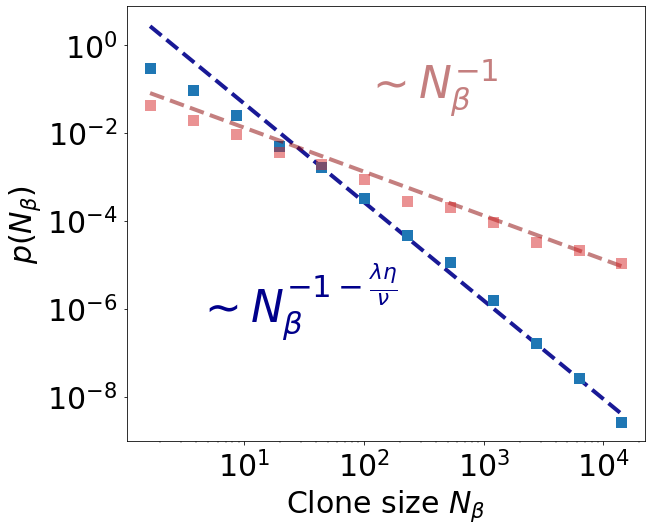

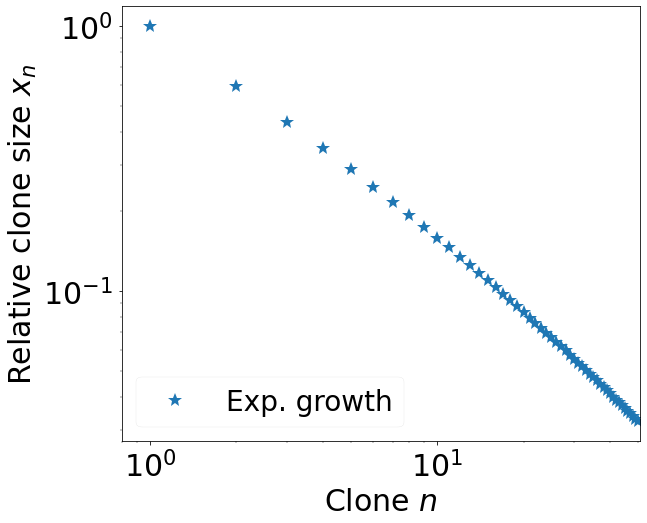

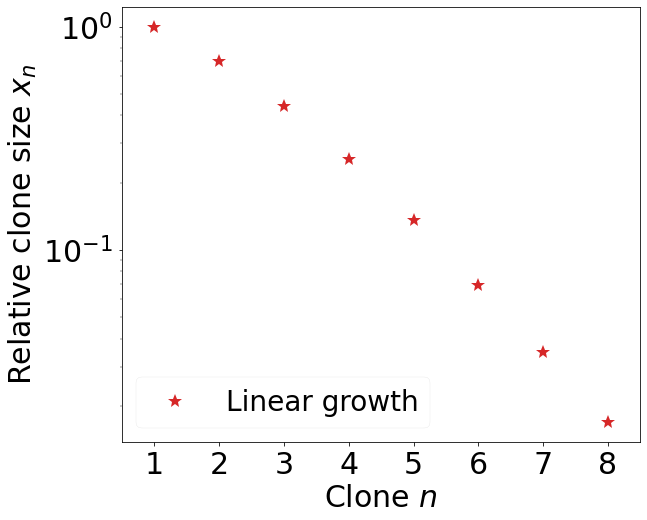

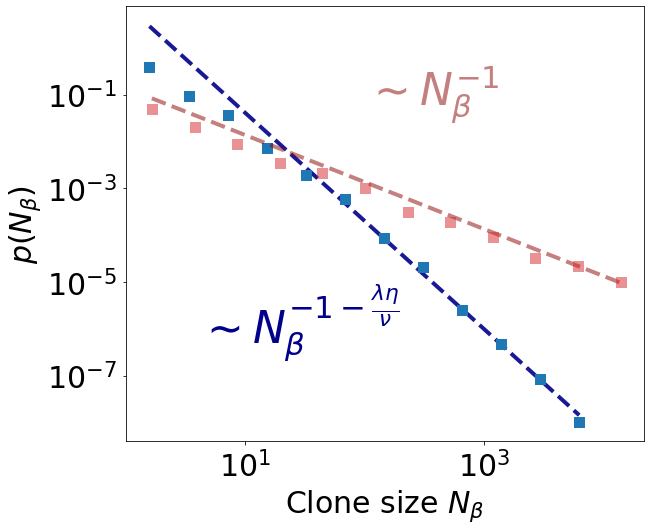

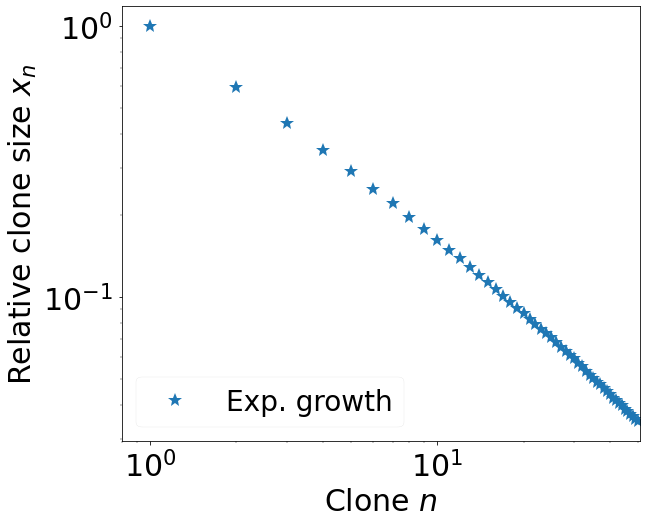

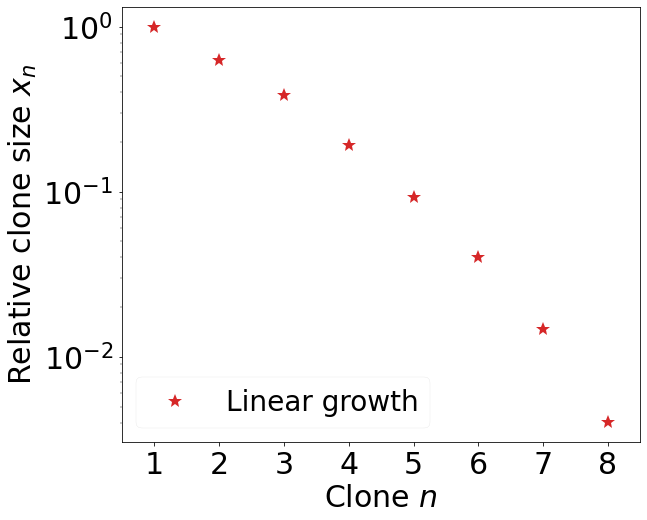

In [22]:
L = 15
NC = 2e3
T0 = 0
Tf = 25
dT = 0.5
eta = 1
gamma = .0000
nu = 0.5

lambd = 0.62

#b = 1.62
#b = 1.97
#b = 2.08
#-------------------------

for Type in Types:

    exponents = [(-((eta*lambd)/nu)-1), -1]
    fig, ax = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})
    fig2, ax2 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})
    fig3, ax3 = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18})

    for i, linear in enumerate(models):

        time = np.linspace(T0, Tf, int((Tf-T0)/dT))
        data_bcells_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/bcells_ensemble_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_eta-%.6f_nu-%.6f_gamma-%.6f_linear-%d_'%(eta, nu, gamma, linear)+Type+'.txt')
        #data_energies_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/energies_tail_ensemble_L-%d_N-%d_Antigen-'%(L, NC)+antigen+'_linear-%d.txt'%(linear))
        N_final_active = np.loadtxt(Text_files_path + "Dynamics/Ensemble/N_final_active_L-%d_N-%d_Antigen-"%(L, NC)+antigen+"_eta-%.6f_nu-%.6f_gamma-%.6f_Linear-%d_"%(eta, nu, gamma, linear)+Type+".txt")

        print('n_data:',len(data_bcells_ensemble),np.sum(N_final_active))

        clone_size_distribution = np.histogram(data_bcells_ensemble, bins = np.logspace(np.log10(np.min(data_bcells_ensemble)),np.log10(np.max(data_bcells_ensemble-1)),14), density = True)

        clone_size = ((clone_size_distribution[1][:-1][np.where(clone_size_distribution[0]!=0)]+clone_size_distribution[1][1:][np.where(clone_size_distribution[0]!=0)]))/2
        clone_size_counts = clone_size_distribution[0][np.where(clone_size_distribution[0]!=0)]

        delta_clone_size = clone_size_distribution[1][1:][np.where(clone_size_distribution[0]!=0)]-clone_size_distribution[1][:-1][np.where(clone_size_distribution[0]!=0)]
        cumsum_clone_size_counts = np.cumsum(clone_size_counts*delta_clone_size)
        #-------------------------

        clone_size_array = np.logspace(np.log10(clone_size[0]), np.log10(clone_size[-2]), 100)

        N_final_active = np.concatenate(([0], N_final_active))
        N_final_active_cum = np.cumsum(N_final_active)

        if(linear==0): #Exponential
            N_clones = 50
            Clone_relative_sizes = np.zeros(N_clones)
            N_ens = 0
            for j, N_final in enumerate(N_final_active_cum[:-1]):
                if(N_final_active[j+1]>=N_clones):
                    N_ens +=1
                    temp_array = np.flip(np.sort(data_bcells_ensemble[int(N_final):int(N_final+N_final_active[j+1])]))
                    #if(j%100==0):
                        #if(models[i]==0): #Exponential
                        #    ax2.plot(range(1,N_clones+1), temp_array[:N_clones]/temp_array[0], color = colors[i], alpha = .1)
                        #if(models[i]==1): #Linear
                        #    ax3.plot(range(1,N_clones+1), temp_array[:N_clones]/temp_array[0], color = colors[i], alpha = .1)

                    for k in range(N_clones):
                        Clone_relative_sizes[k] += (temp_array[k]/temp_array[0])
            print('ensemble size:', N_ens)
            lambd = 0.65
            #-------------------------------------------
            plaw_fit_csd = clone_size**(exponents[i])
            plaw_fit_csd /= (plaw_fit_csd[-4]/(clone_size_counts[-4]))
            print('theory:' ,exponents[i])
            ax.text(x=4e0, y=5e-7, s = r'$\sim N_{\beta}^{-1-\frac{\lambda\eta}{\nu}}$', fontsize=44, color = colors_fit[i])
            #-------------------------------------------
            n_array = np.linspace(1, N_clones, N_clones)
            #ax2.plot(n_array, (lambd*eta*(n_array-1)+1)**(-nu/(lambd*eta)), linestyle = '--', marker = '', ms = 8, linewidth = 4, color=colors_fit[i], alpha = .8)
            ax2.plot(n_array, Clone_relative_sizes/N_ens, color = colors[i], linestyle = '', linewidth = 1.5, marker = '*', ms = 15, label = 'Exp. growth')
            #ax3.text(x=2e1, y=4e-1, s = r'$\sim n^{-1}$', fontsize=44, color = colors_fit[i])
            ax2.set_xlim(left = .8, right = N_clones+1)
            ax.plot(clone_size[:-1][:], plaw_fit_csd[:-1][:], linestyle = '--', marker = '', ms = 8, linewidth = 4, color=colors_fit[i], alpha = .9)
            ax.plot(clone_size[:-1], clone_size_counts[:-1], color = colors[i], linestyle = '', marker = 's', ms = 11, linewidth = 4)

        if(linear==1): #Linear
            N_clones = 8
            Clone_relative_sizes = np.zeros(N_clones)
            N_ens = 0
            for j, N_final in enumerate(N_final_active_cum[:-1]):
                if(N_final_active[j+1]>=N_clones):
                    N_ens +=1
                    temp_array = np.flip(np.sort(data_bcells_ensemble[int(N_final):int(N_final+N_final_active[j+1])]))
                    #if(j%100==0):
                        #if(models[i]==0): #Exponential
                        #    ax2.plot(range(1,N_clones+1), temp_array[:N_clones]/temp_array[0], color = colors[i], alpha = .1)
                        #if(models[i]==1): #Linear
                        #    ax3.plot(range(1,N_clones+1), temp_array[:N_clones]/temp_array[0], color = colors[i], alpha = .1)

                    for k in range(N_clones):
                        Clone_relative_sizes[k] += (temp_array[k]/temp_array[0])
            print('ensemble size:',N_ens)
            a0 = 1e3
            t0 = dT
            lambd = 0.65
            #-------------------------------------------
            plaw_fit_csd = clone_size**(exponents[i])#*(np.log(clone_size**(1/nu)))**(1-lambd)
            plaw_fit_csd /= (plaw_fit_csd[-3]/(clone_size_counts[-3]))
            print('theory:' , exponents[i])
            ax.text(x=1e2, y=6e-2, s = r'$\sim N_{\beta}^{-1}$', fontsize=44, color = colors_fit[i], alpha = .5)
            #-------------------------------------------
            n_array = np.linspace(1, N_clones, N_clones)
            ax3.plot(n_array, Clone_relative_sizes/N_ens, color = colors[i], linestyle = '', linewidth = 1.5, marker = '*', ms = 15, label = 'Linear growth')
            #ax3.plot(n_array, 1*np.exp(-(nu)*((n_array-1)/0.6)**(1/lambd)), linestyle = '--', marker = '', ms = 8, linewidth = 4, color=colors_fit[i], alpha = .8)
            #ax3.text(x=6e0, y=4e-1, s = r'$\sim e^{-\frac{\nu}{\lambda}n}$', fontsize=44, color = colors_fit[i])
            ax3.set_xlim(left = .5, right = N_clones+.5)
            ax3.set_xticks(range(1,N_clones+1))
            ax.plot(clone_size[:-1][:], plaw_fit_csd[:-1][:], linestyle = '--', marker = '', ms = 8, linewidth = 4, color=colors_fit[i], alpha = .5)
            ax.plot(clone_size[:-1], clone_size_counts[:-1], color = colors[i], linestyle = '', marker = 's', ms = 11, linewidth = 4, alpha = .5)
        
        #-------------------------
        #popt, pcov = curve_fit(my_linear_func, np.log(clone_size[5:-1]), np.log(1-cumsum_clone_size_counts[5:-1]))
        #exponent_fit = popt[1]
        #print('fit:',exponent_fit)
        #-------------------------

        #ax.plot(clone_size[:-1][2:], np.exp(my_linear_func(np.log(clone_size[:-1]), *popt))[2:], linestyle = '--', marker = '', ms = '10', linewidth = 3, color='darkred', alpha = .8)

    #-------------------------
    my_plot_layout(ax = ax, xscale='log', yscale= 'log', xlabel=r'Clone size $N_{\beta}$', ylabel=r'$p(N_{\beta})$',
                  ticks_labelsize= 30, x_fontsize=30, y_fontsize=30 )

    my_plot_layout(ax = ax2, xscale='log', yscale= 'log', xlabel=r'Clone $n$', ylabel=r'Relative clone size $x_n$',
                  ticks_labelsize= 30, x_fontsize=30, y_fontsize=30 )
    #ax2.set_xticks(np.logspace(0,3, 20))
    ax2.legend(fontsize = 28, loc = 3)

    my_plot_layout(ax = ax3, xscale='linear', yscale= 'log', xlabel=r'Clone $n$', ylabel=r'Relative clone size $x_n$',
                  ticks_labelsize= 30, x_fontsize=30, y_fontsize=30 )
    ax3.legend(fontsize = 28, loc = 3)
    ax3.set_xticks(range(1,8+1))

    fig.savefig('../Figures/1_Dynamics/Clone_size_distribution_'+Type+'.pdf')
    fig2.savefig('../Figures/1_Dynamics/Relative_CS_1_'+Type+'.pdf')
    fig3.savefig('../Figures/1_Dynamics/Relative_CS_2_'+Type+'.pdf')


-35.66 -43.6


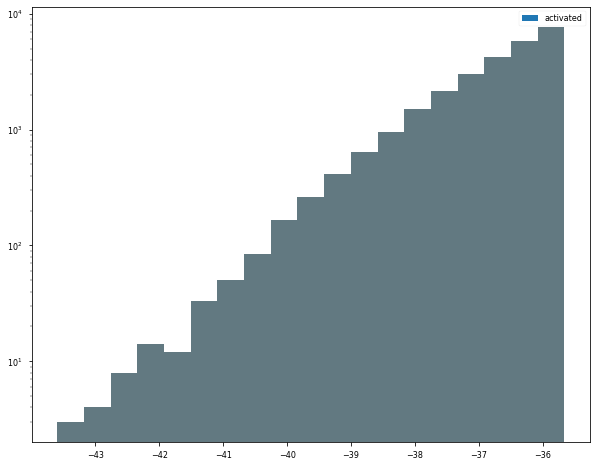

In [9]:
fig, ax = plt.subplots(figsize=(10,8))

ax.hist(data_energies_ensemble[:,0][np.where(data_energies_ensemble[:,1]==1)], bins  = np.linspace(np.min(data_energies_ensemble[:,0]), np.max(data_energies_ensemble[:,0]),20), label = 'activated')
ax.hist(data_energies_ensemble[:,0], bins  = np.linspace(np.min(data_energies_ensemble[:,0]), np.max(data_energies_ensemble[:,0]),20), alpha = 0.3)
ax.legend(loc = 0)
print(np.max(data_energies_ensemble[:,0]), np.min(data_energies_ensemble[:,0]))
ax.set_yscale('log')


## $b(N)$

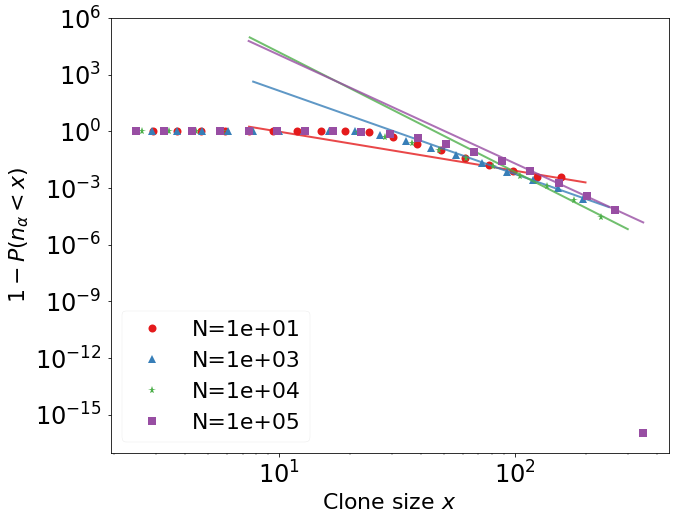

In [12]:
antigens = np.array(['IMLWCMYLILWM', 'TACNSEYPNTTK', 'QRKDGPKQKKEN'])
antigen = 'TACNSEYPNTTK'
T = .5
L = 12
#T0 = 14
#Tf = 22
T0 = 30
Tf = 60
dT = 0.01
beta = 1
gamma = .001
nu = 0.3
time = np.linspace(T0, Tf, int((Tf-T0)/dT))
Ns_dynamics = np.array([1e1, 1e3, 1e4, 1e5])
markers = ['o', '^', '*', 's', 'X']
colors = plt.cm.Set1
exponents_csd = np.array([])
exponents_ds = np.array([])
vars_csd = np.array([])
vars_ds = np.array([])
fig, ax = plt.subplots(figsize = (10,8))
for k, N_dynamics in enumerate(Ns_dynamics):
    # ------- from clone size distribution -------
    data_bcells_ensemble = np.loadtxt(Text_files_path + 'Dynamics/Ensemble/bcells_ensemble_L-%d_N-%d_Antigen-'%(L, N_dynamics)+antigen+'_beta-%.1f_nu-%.1f_gamma-%.3f.txt'%(beta, nu, gamma))
    clone_size_distribution = np.histogram(data_bcells_ensemble, bins = np.logspace(np.log10(np.min(data_bcells_ensemble))-1,np.log10(np.max(data_bcells_ensemble)),20), density = True)
    clone_size = (clone_size_distribution[1][:-1]+clone_size_distribution[1][1:])/2
    clone_size_counts = clone_size_distribution[0]

    delta_clone_size = clone_size_distribution[1][1:]-clone_size_distribution[1][:-1]
    cumsum_clone_size_counts = np.cumsum(clone_size_counts*delta_clone_size)
    ax.plot(clone_size[:], 1-cumsum_clone_size_counts[:], linestyle = '', marker = markers[k], ms = 8, linewidth = 2, label = 'N=%.e'%(N_dynamics), color = plt.cm.Set1(k))

    popt_csd, pcov_csd = curve_fit(my_linear_func, np.log(clone_size[np.where((1-cumsum_clone_size_counts)!=1)][-5:-1]), np.log(1-cumsum_clone_size_counts[np.where((1-cumsum_clone_size_counts)!=1)][-5:-1]))
    
    exponents_csd = np.append(exponents_csd, popt_csd[1])
    vars_csd = np.append(vars_csd, pcov_csd[1,1])
    
    ax.plot(clone_size[4:], np.exp(my_linear_func(np.log(clone_size[4:]), *popt_csd)), linestyle = '-', marker = '', ms = '10', linewidth = 2, color=plt.cm.Set1(k), alpha= .8)


    # ------- from density of sequences -------
    data_dynamics_tail=np.loadtxt(Text_files_path + 'Dynamics/ensemble/energies_tail_ensemble_L-%d_N-%d_Antigen-'%(L, N_dynamics)+antigen+'.txt')
    data_dynamics_tail_rho = np.histogram(data_dynamics_tail[:,0], bins = 8, density = False) # Creating histograms
    e_dynamics_tail = data_dynamics_tail_rho[1][:-1] + abs(data_dynamics_tail_rho[1][1:]-data_dynamics_tail_rho[1][:-1])/2
    rho_e_dynamics_tail = data_dynamics_tail_rho[0]*1e8
    e_lineal = e_dynamics_tail[:4]
    rho_e_lineal = rho_e_dynamics_tail[:4]
    popt_ds, pcov_ds = curve_fit(my_linear_func, e_lineal, np.log(rho_e_lineal), p0 = (60,1))
    
    exponents_ds = np.append(exponents_ds, (popt_ds[1]*beta)/nu)
    vars_ds = np.append(vars_ds, pcov_ds[1,1])
    
    
ax.set_xlabel('Clone size $x$', fontsize = 22)
ax.set_ylabel(r'$1-P(n_{\alpha}<x)$', fontsize = 22)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize = 24)
ax.legend(fontsize = 22, loc = 0)
#fig.savefig('../Figures/1_Dynamics/Clone_size_distribution_N.png')


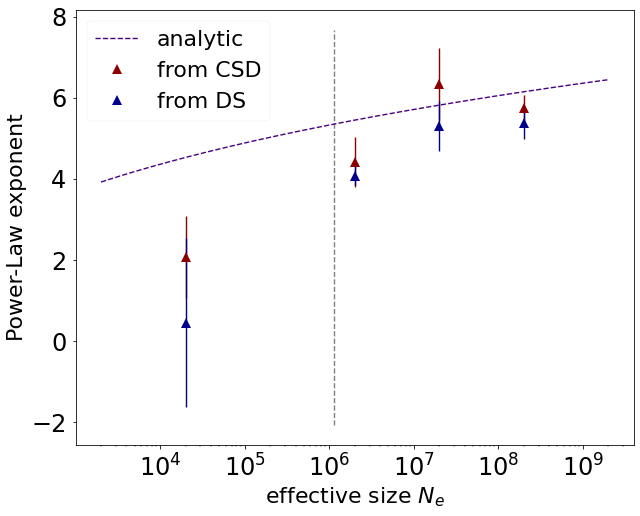

In [13]:
mean_e =-28.945951714884234
var_e = 9.378153782122688
N_array=np.logspace(0, 6, 100)
N_ensemble = 2e3
e = np.linspace(-45.5, -40.2, 5)
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(N_array*N_ensemble, ((-1*((-np.exp(3.5)*(np.log10(N_array*N_ensemble)**(0.15770589)))-mean_e)/(var_e))*beta/nu), linestyle = '--', color = 'indigo', label = 'analytic')
ax.plot(Ns_dynamics*N_ensemble, -exponents_csd, marker = '^', color = 'darkred', linestyle = '', ms = 10, label = 'from CSD')
ax.errorbar(x = Ns_dynamics*N_ensemble, y = -exponents_csd, yerr = 1.96*np.sqrt(vars_csd), color = 'darkred', linestyle = '', capsize = 4)
ax.plot(Ns_dynamics*N_ensemble, exponents_ds, marker = '^', color = 'darkblue', linestyle = '', ms = 10, label = 'from DS')
ax.errorbar(x = Ns_dynamics*N_ensemble, y = exponents_ds, yerr = 1.96*(np.sqrt(vars_ds)*beta)/nu, color = 'darkblue', linestyle = '', capsize = 4)
ax.vlines(10**((44/np.exp(3.5))**(1/0.15770589)), ax.get_ylim()[0], ax.get_ylim()[1], linestyle = 'dashed', color = 'grey')

ax.set_xlabel('effective size $N_{e}$', fontsize = 22)
ax.set_ylabel('Power-Law exponent', fontsize = 22)
ax.tick_params(labelsize = 24)
#ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(fontsize = 22, loc = 0)
#fig.savefig('../Figures/1_Dynamics/Exponent_clone_size_distribution_N.png')

In [3]:
%%time
n_seq = 500000

#Sequences = generate_Sequences(n_seq, Energy_Matrix = )
#pickle.dump( Sequences, open( "../Text_files/Sequences-n_seq-%d.pkl"%(n_seq), "wb" ) )

Sequences = pickle.load( open( "../Text_files/Sequences_MJ2-n_seq-%d.pkl"%(n_seq), "rb" ) )

#print_raw_file(Sequences, "../Text_files/file2.txt")
#generate_newick_format("../Text_files/file2.txt")



CPU times: user 3.28 s, sys: 318 ms, total: 3.6 s
Wall time: 3.44 s


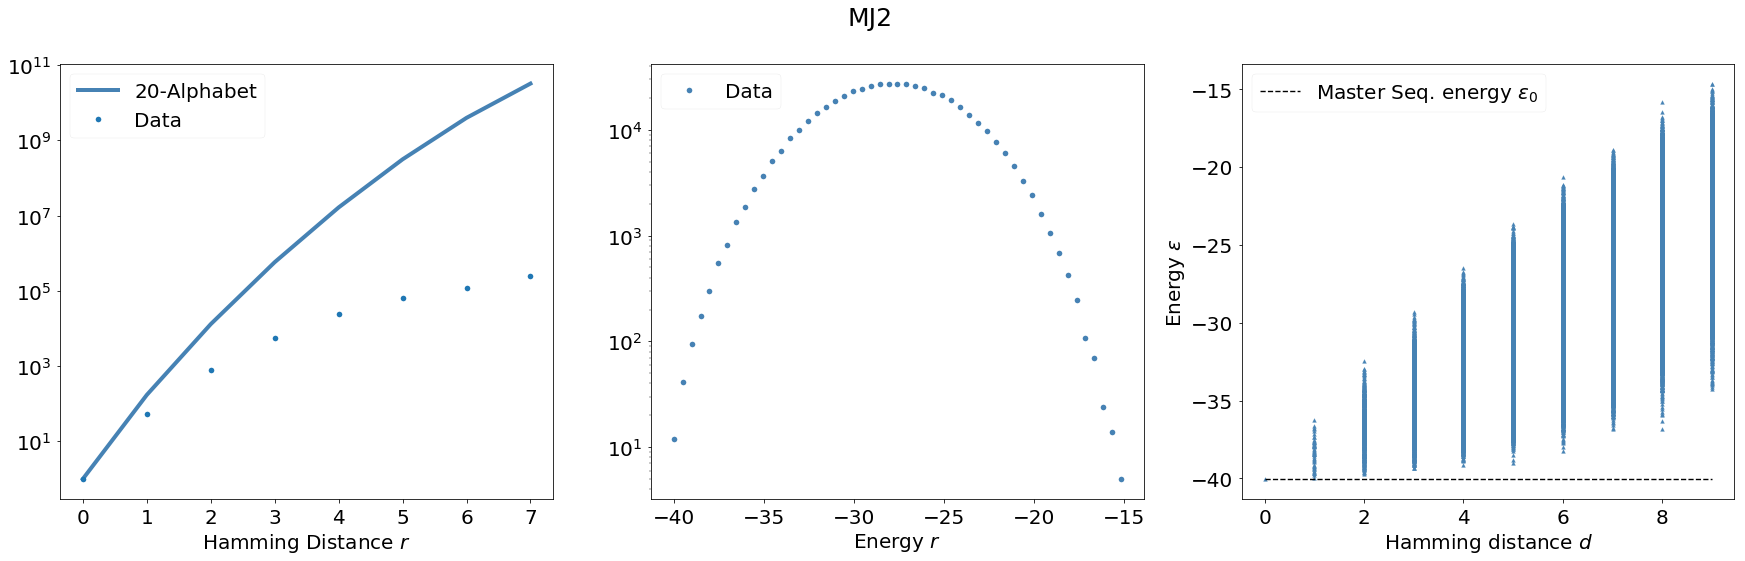

In [4]:
fig, ax = plt.subplots(1,3,figsize=(30,8))
fig.suptitle('MJ2', fontsize = 25)
distances = plot_histogram_hamming_distance(Sequences = Sequences, ax = ax[0])
energies, data_energies = plot_histogram_energy(Sequences = Sequences, bins = 51, ax = ax[1])
plot_scatter_hamming_distance_energy(distances = distances, energies = energies, ax = ax[2])

fig.savefig('../Figures/Sequences_MJ2-n_seq-%d.png'%(n_seq))


(-40.03, -35.03)

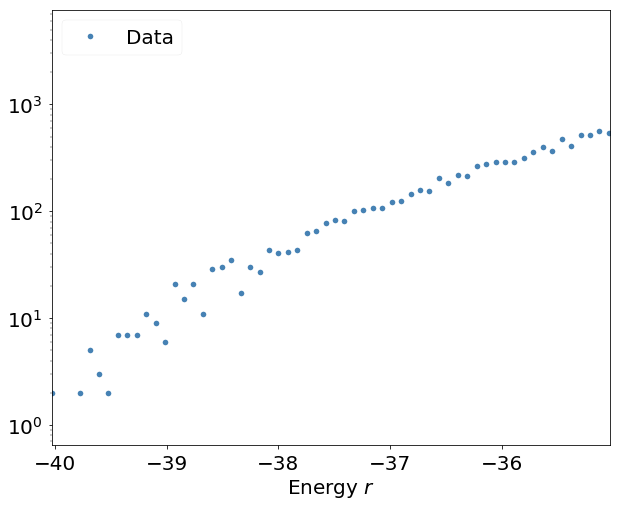

# Deterministic Simulation

In [52]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 1
R=6
beta = 1
gamma = 1
T = 25
master_Sequence_energy = 0
dt = 0.002
Sub_Sequences = np.random.choice(Sequences, n_linages)
for i in range(n_linages):
    Sub_Sequences[i].active = False
Model  = Deterministic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma, 
                                  nu = nu, R = R, beta = beta, master_Sequence_energy = master_Sequence_energy, 
                                  dt = dt)
Model.ODE()


CPU times: user 12.6 s, sys: 43 ms, total: 12.6 s
Wall time: 12.7 s


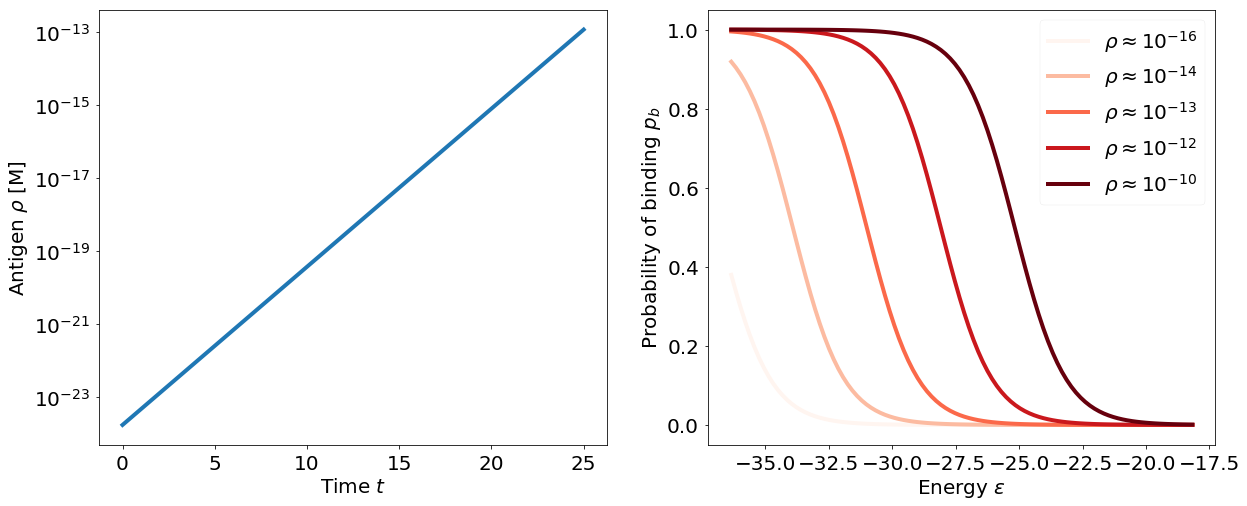

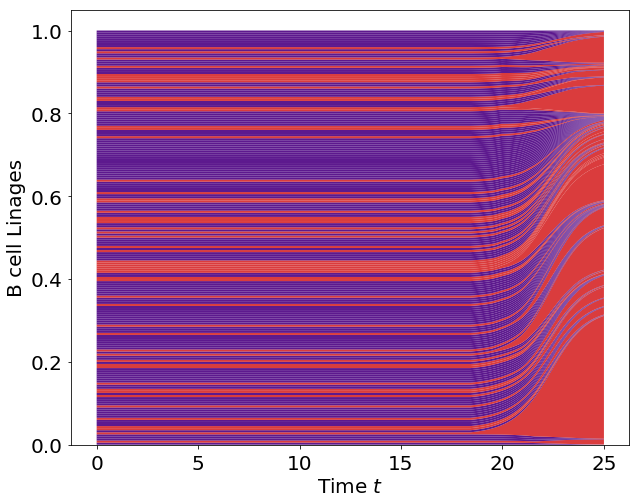

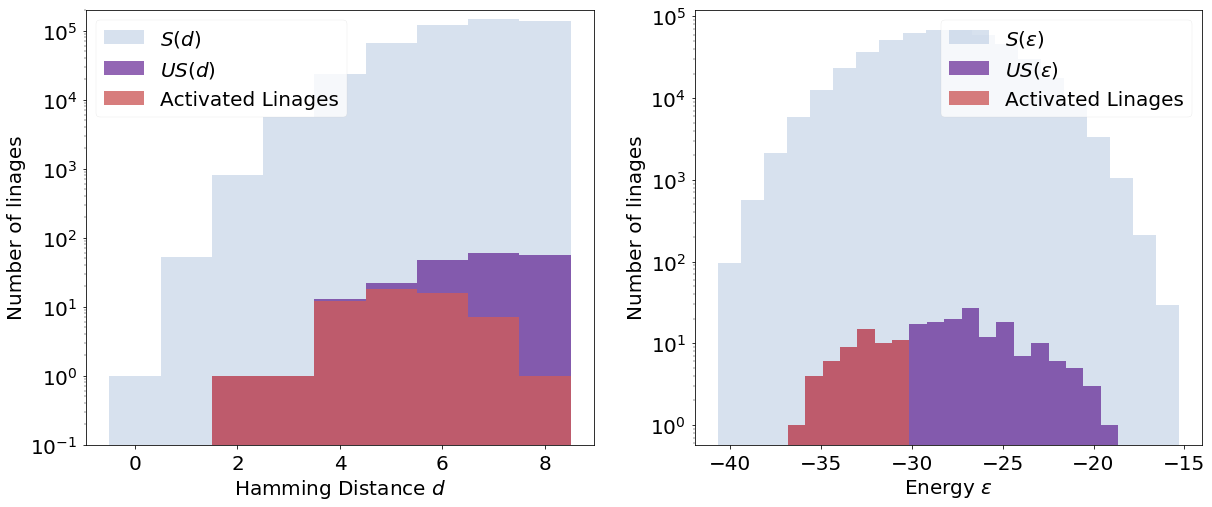

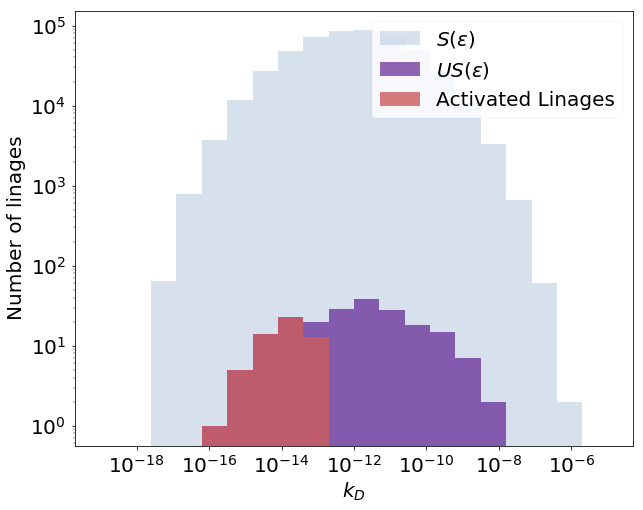

In [53]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
Model.plot_antigen_time(ax = ax[0])
Model.plot_prob_binding(ax = ax[1])
ax[1].set_yscale('linear')
counter = 0
while(os.path.isfile('../Figures/Antigen_Binding_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Antigen_Binding_%d.png'%(0))
#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(10,8))
Model.stackplot_linages_time(antigen = False, time = True, ax = ax)
counter = 0
while(os.path.isfile('../Figures/Linages_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Linages_%d.png'%(0))
#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,2,figsize=(20,8))
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[0])
Model.hist_sequences_energy(Sequences = Sequences, bins = 20, ax = ax[1])
counter = 0
while(os.path.isfile('../Figures/Histograms_hamming_energy_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Histograms_hamming_energy_%d.png'%(0))
#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(10,8))
Model.hist_sequences_k_D(Sequences = Sequences, bins = np.logspace(-19, -5, 21), ax = ax)
ax.set_xscale('log')
ax.set_xlabel(r'$k_D$', fontsize = 20)
counter = 0
while(os.path.isfile('../Figures/Histogram_k_D_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Histogram_k_D_%d.png'%(0))


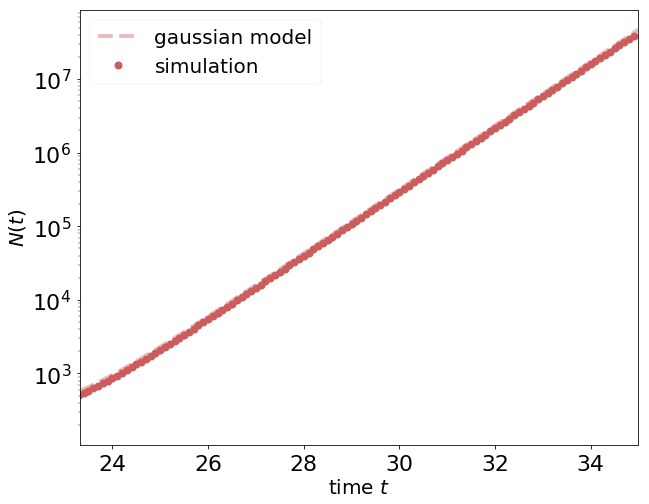

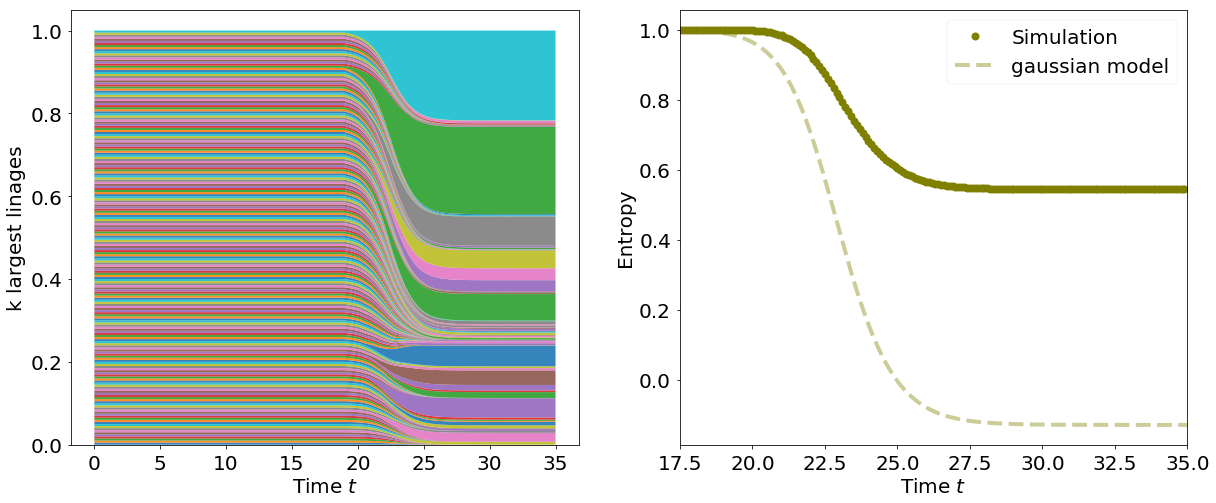

In [26]:
popt = np.array([ 1.35847161e+05, -4.92212036e-02, -2.79453873e+01])

fig, ax = plt.subplots(1,1,figsize=(10,8))
t_new = np.linspace(0, T, int(T/dt))
N_total = np.array([np.cumsum(np.exp(t-np.linspace(0,t, 100))*(1.7e2/5e5)*np.exp(my_quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt))*(t/100))[-1] + 200 - np.cumsum((2e2/5e5)*np.exp(my_quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt))*(t/100))[-1] for t in t_new])
ax.plot(t_new, N_total, linestyle = '--', linewidth = 4, color = 'indianred', alpha = 0.4, label = 'gaussian model')
ax.plot(Model.time_series[::50], np.sum(Model.linages_time_series, axis=0)[::50], marker = 'o', ms = 8, color = 'indianred', linestyle = '', label = 'simulation')
ax.set_xlabel(r'time $t$', fontsize = 20)
ax.set_ylabel(r'$N(t)$', fontsize = 20)
ax.tick_params(labelsize = 22)
ax.set_yscale('log')
ax.set_xlim(2*T/3, T)
ax.legend(loc = 0, fontsize = 20)
counter = 0
while(os.path.isfile('../Figures/N_total_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/N_total_%d.png'%(0))

#--------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(1,2,figsize=(20,8))
t_new = np.linspace(0, T, int(T/dt))

N_alpha_log_N_alpha = np.array([np.cumsum((np.exp(t-np.linspace(0,t, 100))*(t-np.linspace(0,t, 100))*(1.7e2/5e5)*np.exp(my_quadratic_func(np.log(np.exp(np.linspace(0,t, 100))/N_A), *popt)))*(t/100))[-1] for t in t_new])

biggest_k_linages_freq = Model.plot_k_largest_linages(k=200, ax=ax[0])
Model.plot_normalized_entropy_k_largest_linages(k=200, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[1])

ax[1].plot(t_new, ((-1/N_total)*(N_alpha_log_N_alpha) + np.log(N_total))/np.log(n_linages), linestyle = '--', linewidth = 4, color = 'olive', alpha = 0.4, label = 'gaussian model')
ax[1].legend(loc = 0, fontsize = 20)
ax[1].set_xlim(1*T/2, T)
counter = 0
while(os.path.isfile('../Figures/Entropy__%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Entropy__%d.png'%(0))


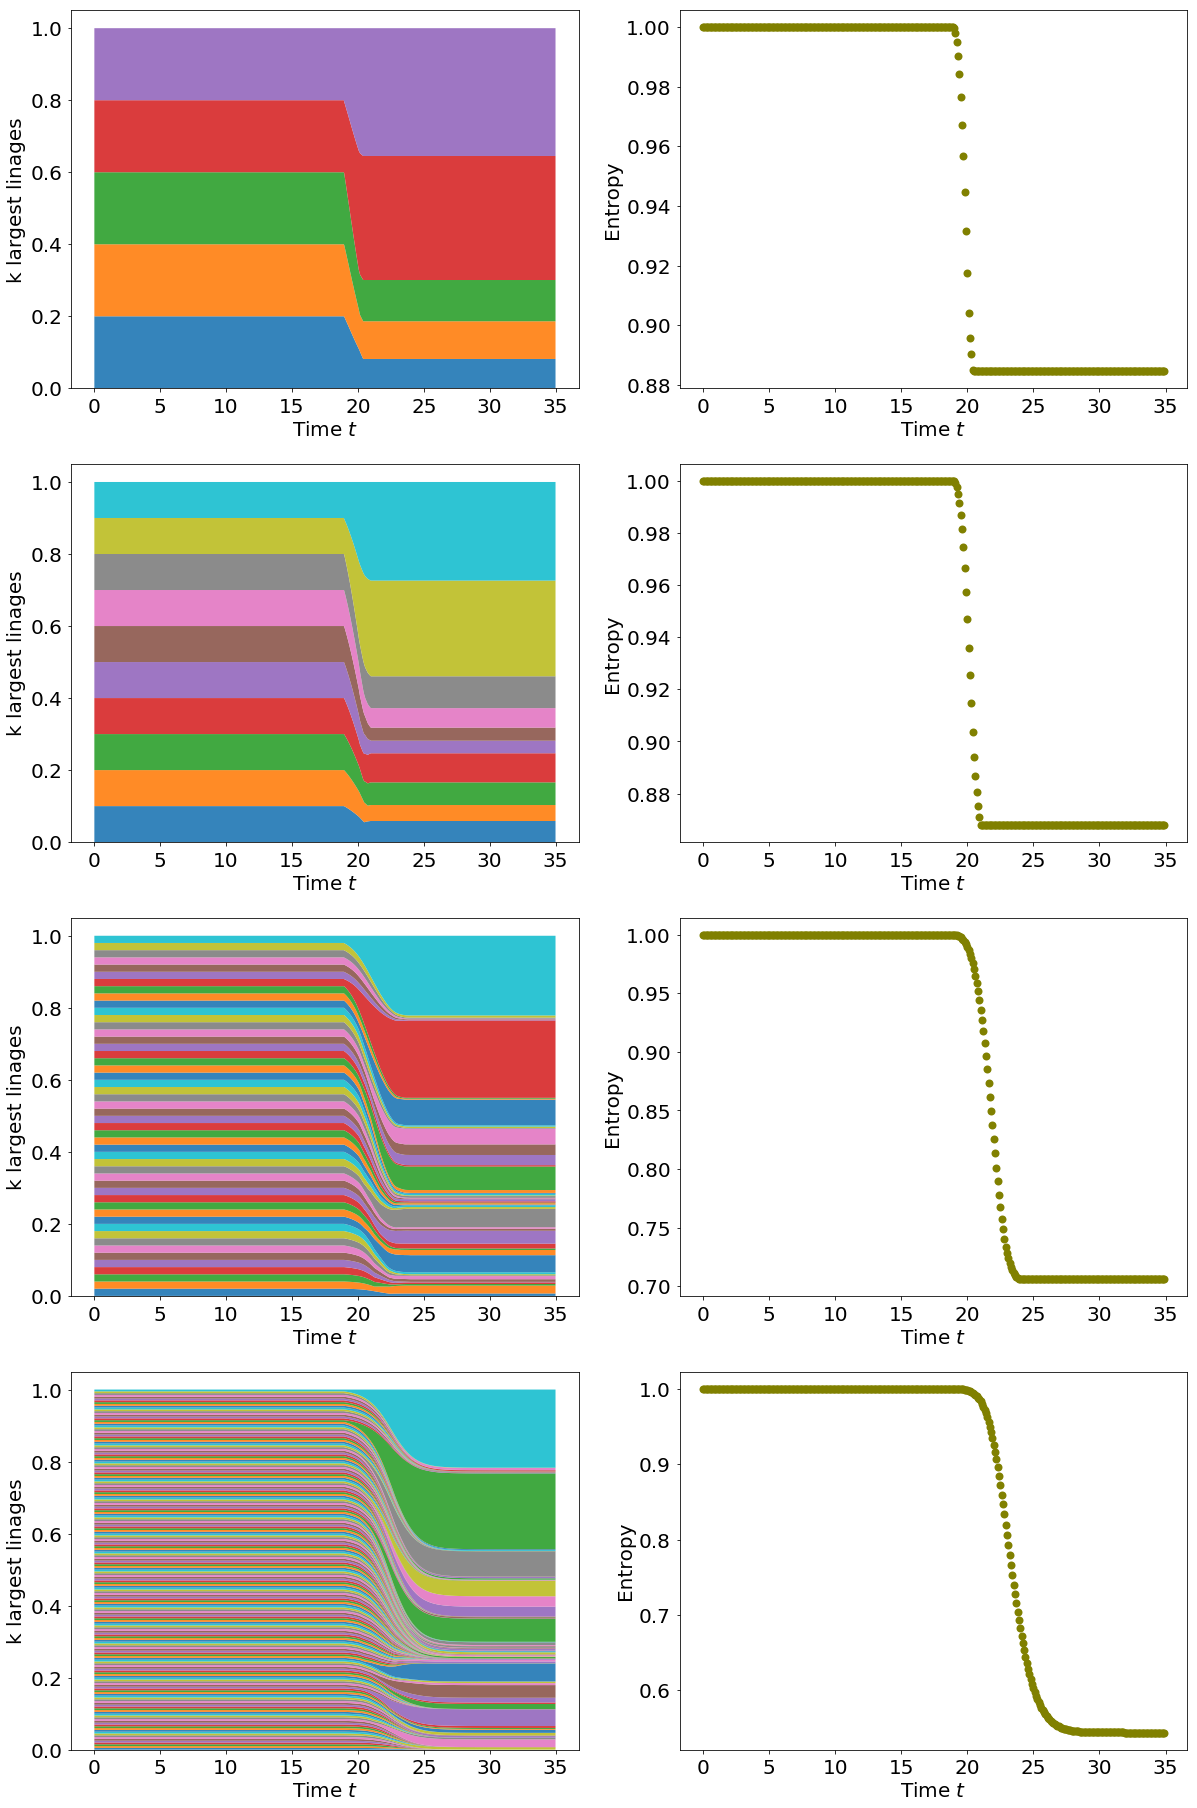

In [9]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

entropy_drop = np.array([0])
k_array = np.array([0, 5, 10, 50, 200])
for i, k in enumerate(k_array[1:]):

    biggest_k_linages_freq = Model.plot_k_largest_linages(k=k, ax=ax[i,0])
    normalized_entropy = Model.plot_normalized_entropy_k_largest_linages(k=k, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[i,1])
    entropy_drop = np.append(entropy_drop, normalized_entropy[-1] - normalized_entropy[0])
    
counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
fig.savefig('../Figures/Entropy_%d.png'%(0))

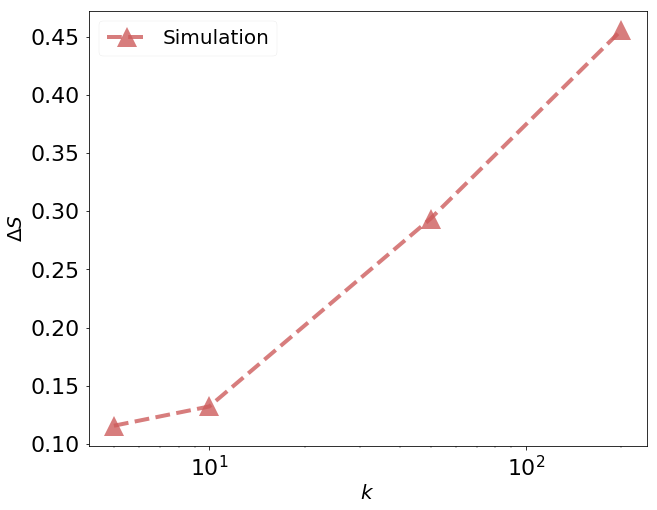

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(k_array[1:], abs(entropy_drop)[1:], linestyle = '--', marker = '^', ms = 20, linewidth = 4, color = 'indianred', alpha = 0.8, label = 'Simulation')
ax.set_xlabel(r'$k$', fontsize = 20)
ax.set_ylabel(r'$\Delta S$', fontsize = 20)
ax.tick_params(labelsize = 22)
ax.set_xscale('log')
#ax.set_ylim(0.1,1)
#ax.set_xlim(,n_linages*2)
ax.legend(loc = 0, fontsize = 20)
counter = 0
while(os.path.isfile('../Figures/Entropy_drop_%d.png'%(counter))):
    counter+=1
fig.savefig('../Figures/Entropy_drop_%d.png'%(0))


In [47]:
Sequences_tree = pickle.load( open( "../Text_files/Sequences_MJ2-n_seq-%d.pkl"%(10000), "rb" ) )

In [49]:
np.min([Sequences_tree[i].energy for i in range(10000)])

-42.66

## Stochastic Simulation - Stochastic antigen dynamics

In [ ]:
%%time
n_linages = 200
U = n_linages/n_seq
nu = 0.0004
R=6
beta = 0.001
gamma = 1
T = 5
master_Sequence_energy = 0
Sub_Sequences = np.random.choice(Sequences, n_linages)
Model = Stochastic_simulation(Sequences = Sub_Sequences, n_linages=n_linages, T = T, U = U, gamma = gamma,
                              nu = nu, R = R, beta = beta, master_Sequence_energy = master_Sequence_energy)
Model.Gillespie()



## Plot linages

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(20,24))

plot_energy_matrix(Energy_Matrix=M2, Alphabet = Alphabet, title = 'MJ 1996', ax = ax[0,0])
Model.plot_antigen_time(ax = ax[0,1])
Model.plot_prob_binding(ax = ax[1,0])
Model.stackplot_linages_time(antigen = False, time = True, ax = ax[1,1])
Model.hist_sequences_hamming_distance(Sequences = Sequences, ax = ax[2,0])
Model.hist_sequences_energy(Sequences = Sequences, bins = 20, ax = ax[2,1])


counter = 0
while(os.path.isfile('../Figures/Antigen_Linages_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Antigen_Linages_%d.png'%(counter))


## entropy

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(20,32))

for i, k in enumerate([4, 10, 50, 100]):

    biggest_k_linages_freq = Model.plot_k_largest_linages(k=k, ax=ax[i,0])
    Model.plot_entropy_k_largest_linages(k=k, biggest_k_linages_freq = biggest_k_linages_freq, ax=ax[i,1])

counter = 0
while(os.path.isfile('../Figures/Entropy_%d.png'%(counter))):
    counter+=1
    
#fig.savefig('../Figures/Entropy_%d.png'%(counter))


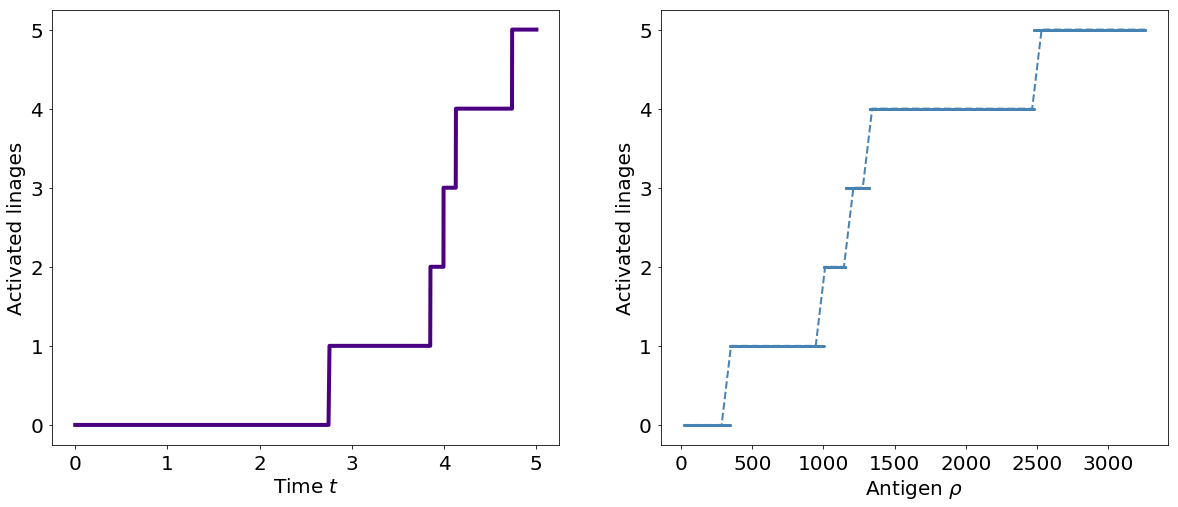

In [28]:
activation_time_series = [np.sum(Model.activation_time_series[:,i]) for i in range(int(len(Model.activation_time_series[0,:])))]
f = interp1d(Model.antigen_time_series, activation_time_series)
x_new = np.linspace(20, np.max(Model.antigen_time_series), 50)

fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].plot(Model.time_series, activation_time_series, linewidth = 4, color = 'indigo')
ax[0].set_xlabel(r'Time $t$', fontsize = 20)
ax[0].set_ylabel(r'Activated linages', fontsize = 20)
ax[0].tick_params(labelsize = 20)
#ax[0].set_yscale('log')
#ax[0].legend(loc = 0, fontsize = 20)

ax[1].plot(Model.antigen_time_series, activation_time_series, '.', ms = 5, linewidth = 4, color = 'steelblue')
ax[1].plot(x_new, f(x_new), '--', linewidth = 2, color = 'steelblue')
ax[1].set_xlabel(r'Antigen $\rho$', fontsize = 20)
ax[1].set_ylabel(r'Activated linages', fontsize = 20)
ax[1].tick_params(labelsize = 20)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].legend(loc = 0, fontsize = 20)



In [1]:
a = 4

In [3]:
2*(3>a)

0

In [64]:
antigen = 1e8/N_A
display(Math(r'\textrm{Antigen concentration = }%.2e M'%(antigen)))
k_D = np.exp(Sequences[10].energy)
display(Math(r'\epsilon=%.3f'%(Sequences[10].energy)))
display(Math((r'$k_D=%.2e$'%(k_D))))
display(Math(r'f=%.6f'%(antigen/(antigen+k_D))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

1.6605390671738466e-15

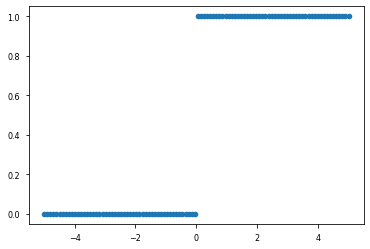

In [17]:
x = np.linspace(-5,5,100)
plt.plot(x, np.heaviside(x,1), 'o')

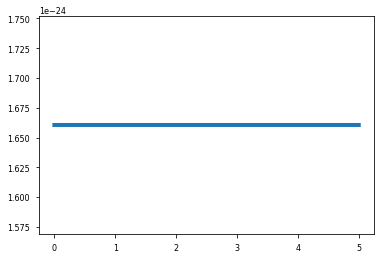

In [10]:
plt.plot(Model.time_series, np.transpose(Model.antigen_time_series)/N_A, linewidth  = 4)

In [15]:
Model.antigen_time_series[0,0:2]

array([1., 1.])